(mmm_media_saturation)=
# Understanding Media Saturation in Marketing Mix Models

One of the most important concepts in Marketing Mix Modeling (MMM) is **media saturation** - the phenomenon where the incremental impact of advertising spend diminishes as spending increases. Understanding saturation is crucial for making optimal budget allocation decisions.

This tutorial explores two complementary ways to visualize and understand media saturation after fitting an MMM.

1. **Direct/Marginal Contribution** (`saturation_scatterplot`) - Shows the relationship between spend and contribution at each time point.

2. **Total Contribution over Spend Share** (`mmm.plot.channel_contribution_grid`) - Shows how total contribution changes as you scale overall spend

```{warning}
These two visualizations answer different questions and are often confused. This tutorial clarifies the distinction and provides guidance on when to use each.
```

## Setup and Data Preparation

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import seaborn as sns
from pymc_extras.prior import Prior

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM
from pymc_marketing.paths import data_dir

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.12/site-packages/preliz/ppls/pymc_io.py:12: FutureWarning: `pytensor.graph.basic.ancestors` was moved to `pytensor.graph.traversal.ancestors`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import ancestors
/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.12/site-packages/pymc_extras/model/marginal/graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort
/Users/carlostrujillo/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/multidimensional.py:218: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)
/Users/carl

In [2]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Understanding the Saturation Curve

Before diving into the visualizations, let's understand what a saturation curve represents. In this notebook we consider the **logistic saturation function**:

$$
f(x) = \beta \cdot \frac{1 - e^{-\lambda x}}{1 + e^{-\lambda x}}
$$



Where:
- $x$ is the (adstocked) media spend
- $\beta$ is the **saturation ceiling** - the maximum contribution a channel can achieve
- $\lambda$ is the **efficiency parameter** - how quickly the curve approaches saturation



PyMC-Marketing provides the {class}`~pymc_marketing.mmm.components.saturation.LogisticSaturation` class to work with this transformation. This class allows us to:
- Define custom priors for the parameters
- Sample from the prior distributions
- Visualize the saturation curves

Let's explore how to use this class and understand how the parameters affect the saturation curve.

In [3]:
# Create a LogisticSaturation instance with default priors
saturation = LogisticSaturation()

# View the default priors for the saturation parameters
saturation.default_priors

{'lam': Prior("Gamma", alpha=3, beta=1), 'beta': Prior("HalfNormal", sigma=2)}

```{note}
PyMC-Marketing provides many other saturation functions like {class}`~pymc_marketing.mmm.components.saturation.HillSaturation` and {class}`~pymc_marketing.mmm.components.saturation.MichaelisMentenSaturation`.
```

Before doing any sampling, let's get an intuition of how the parameters affect the saturation curve.

/var/folders/f0/rbz8xs8s17n3k3f_ccp31bvh0000gn/T/ipykernel_75791/1421674359.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


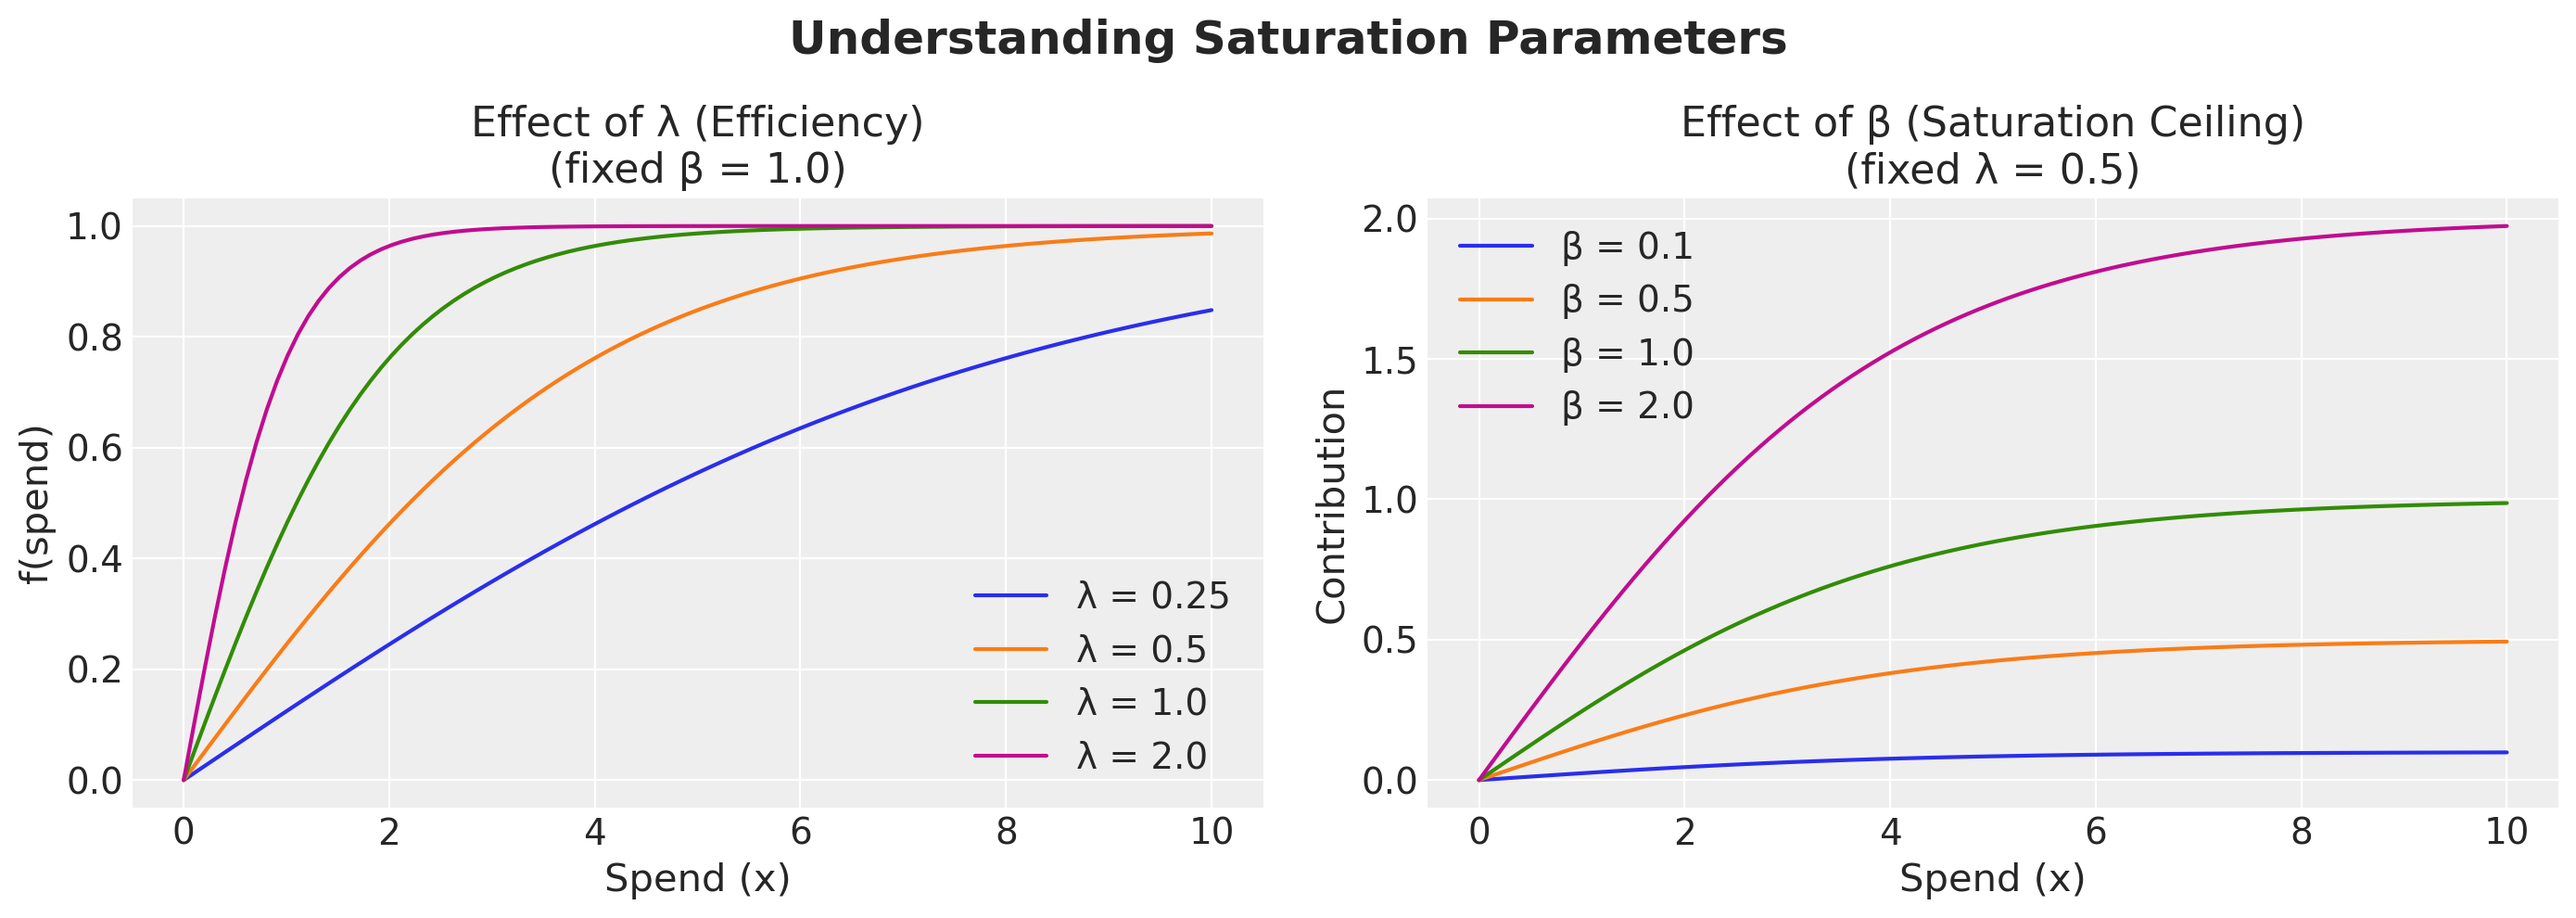

In [4]:
x = np.linspace(0, 10, 100)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Effect of lambda (efficiency) - using the transformer function
ax = axes[0]
for lam in [0.25, 0.5, 1.0, 2.0]:
    y = saturation.function(x, lam=lam, beta=1.0).eval()
    ax.plot(x, y, label=f"λ = {lam}")

ax.legend()
ax.set(
    title="Effect of λ (Efficiency)\n(fixed β = 1.0)",
    xlabel="Spend (x)",
    ylabel="f(spend)",
)

# Effect of beta (saturation ceiling) - using the class function
ax = axes[1]
for beta in [0.1, 0.5, 1.0, 2.0]:
    y = saturation.function(x, lam=0.5, beta=beta).eval()
    ax.plot(x, y, label=f"β = {beta}")

ax.set(
    title="Effect of β (Saturation Ceiling)\n(fixed λ = 0.5)",
    xlabel="Spend (x)",
    ylabel="Contribution",
)
ax.legend()

fig.suptitle("Understanding Saturation Parameters", fontsize=18, fontweight="bold")
plt.tight_layout()

**Key observations:**
- Higher $\beta$ → Higher maximum contribution (the curve's ceiling)
- Higher $\lambda$ → Faster saturation (the curve rises more steeply but plateaus sooner)



Next, we show how to sample from the prior distributions and visualize the saturation curves.

Sampling: [saturation_beta, saturation_lam]
Sampling: []


Output()

/var/folders/f0/rbz8xs8s17n3k3f_ccp31bvh0000gn/T/ipykernel_75791/1141326037.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


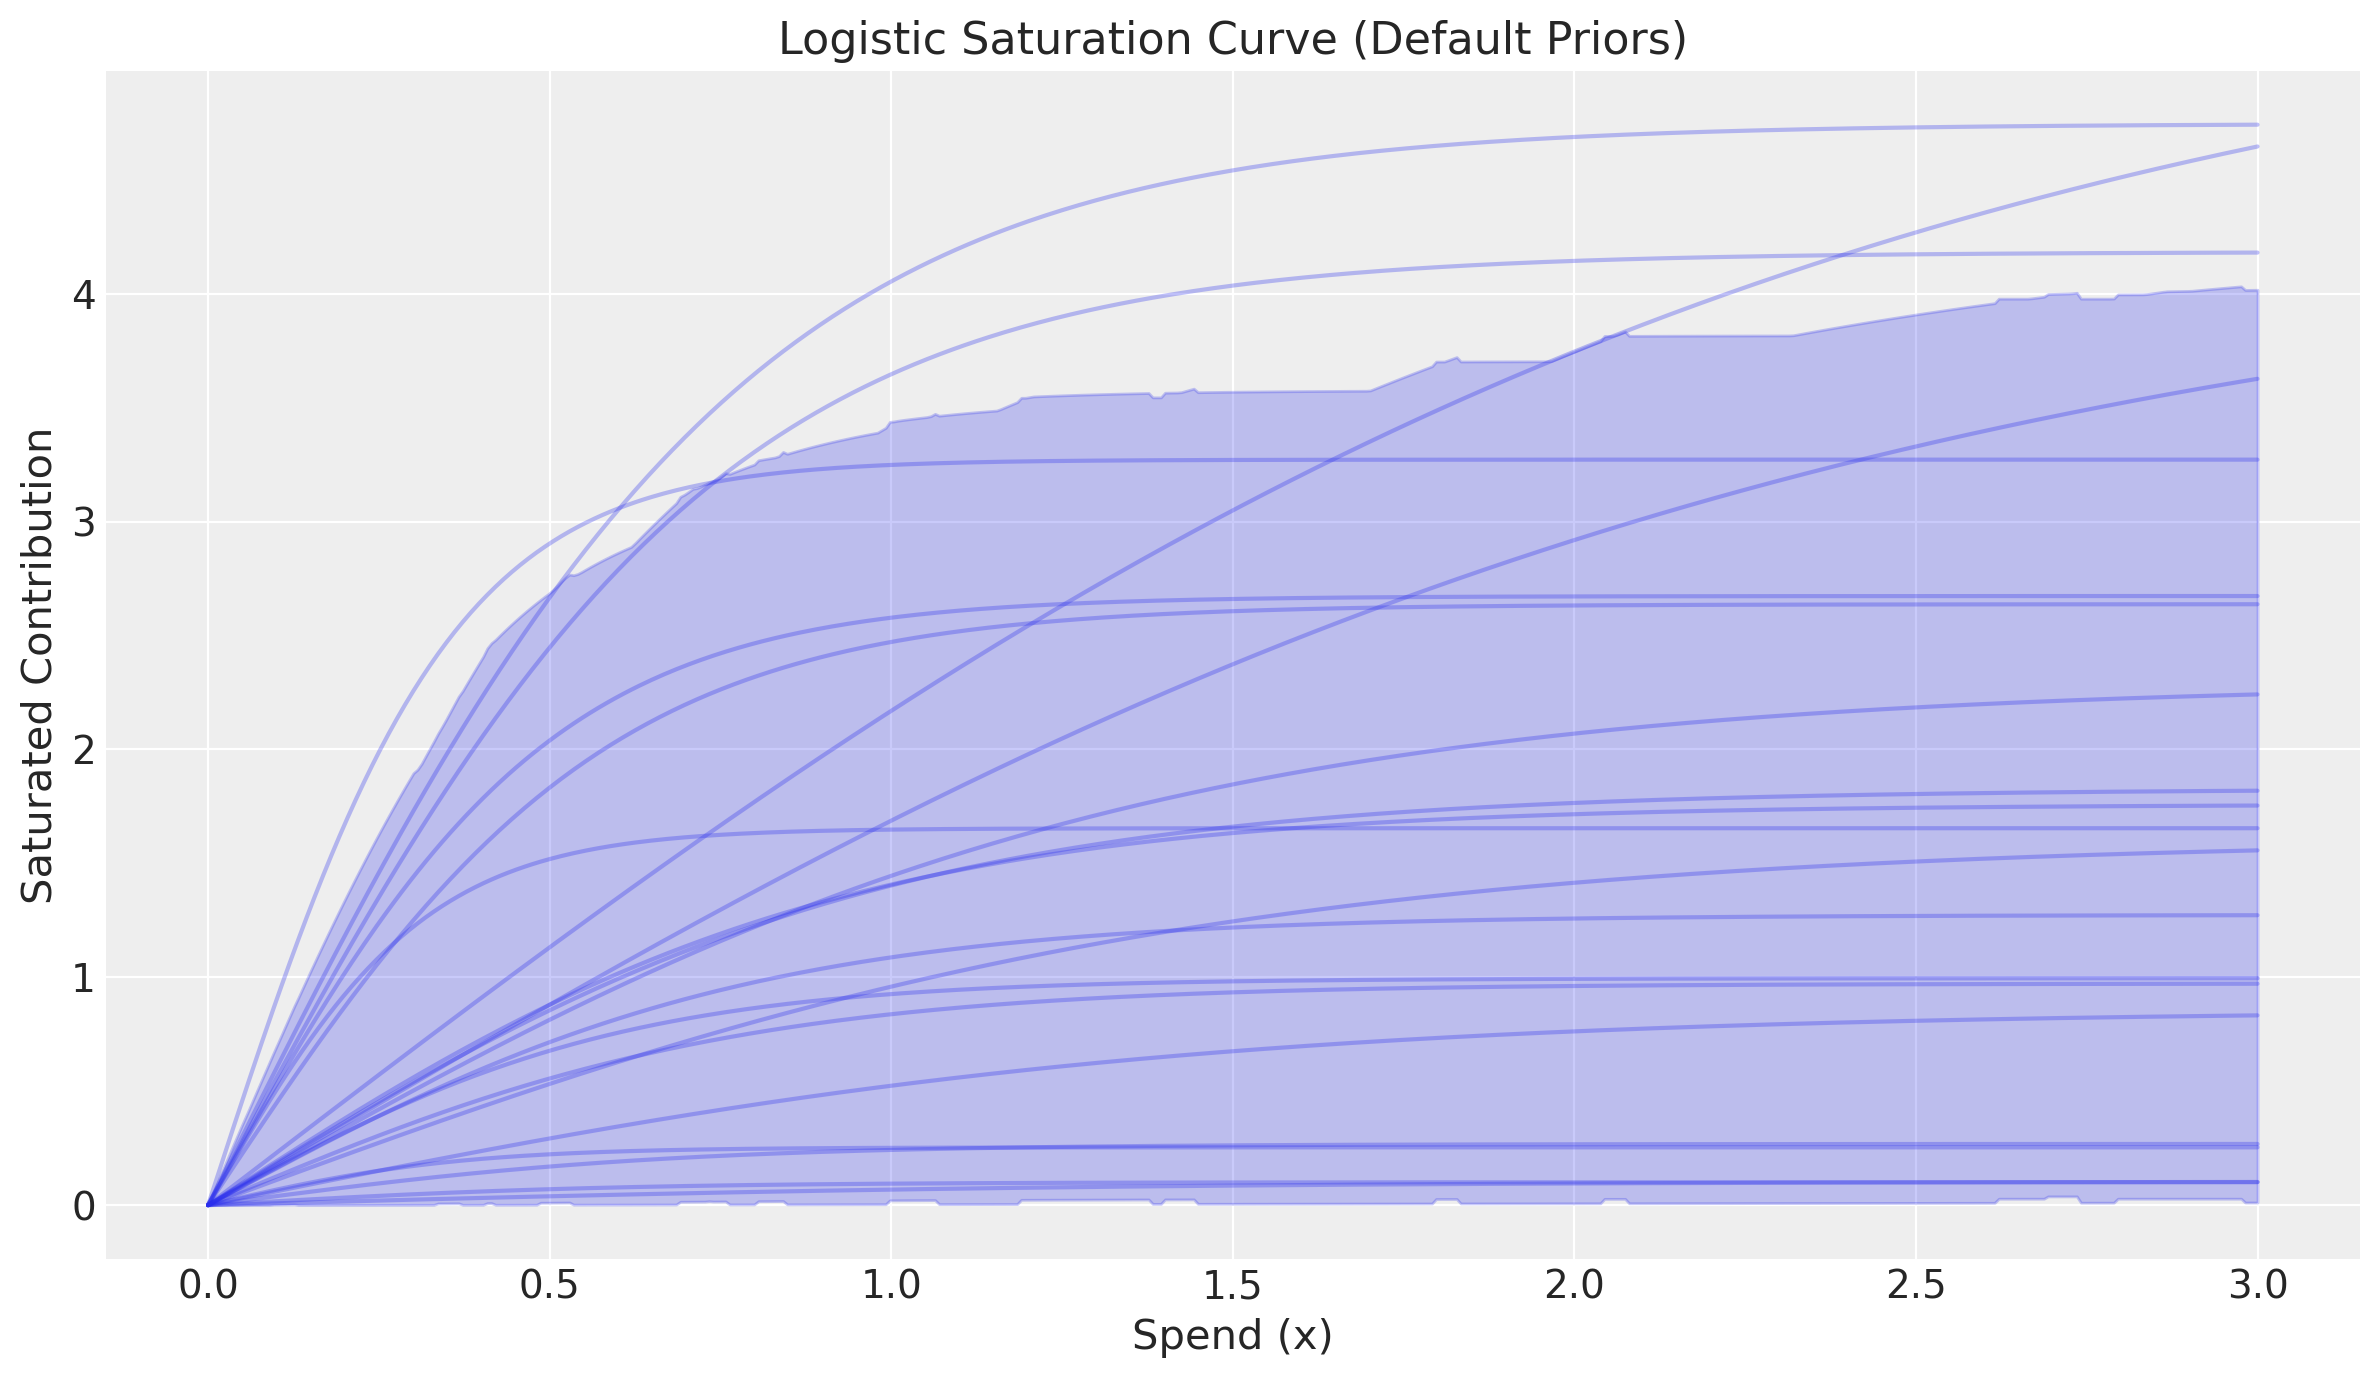

In [5]:
# Sample from the prior distributions
prior = saturation.sample_prior(random_seed=rng)

# Sample the saturation curve across a range of spend values
curve = saturation.sample_curve(prior, num_points=500, max_value=3)

# Plot the saturation curve with uncertainty (HDI and samples)
fig, axes = saturation.plot_curve(curve, n_samples=20, random_seed=rng)
axes[0].set(
    xlabel="Spend (x)",
    ylabel="Saturated Contribution",
    title="Logistic Saturation Curve (Default Priors)",
)
plt.tight_layout()

Let's do the same thing with more tight priors.

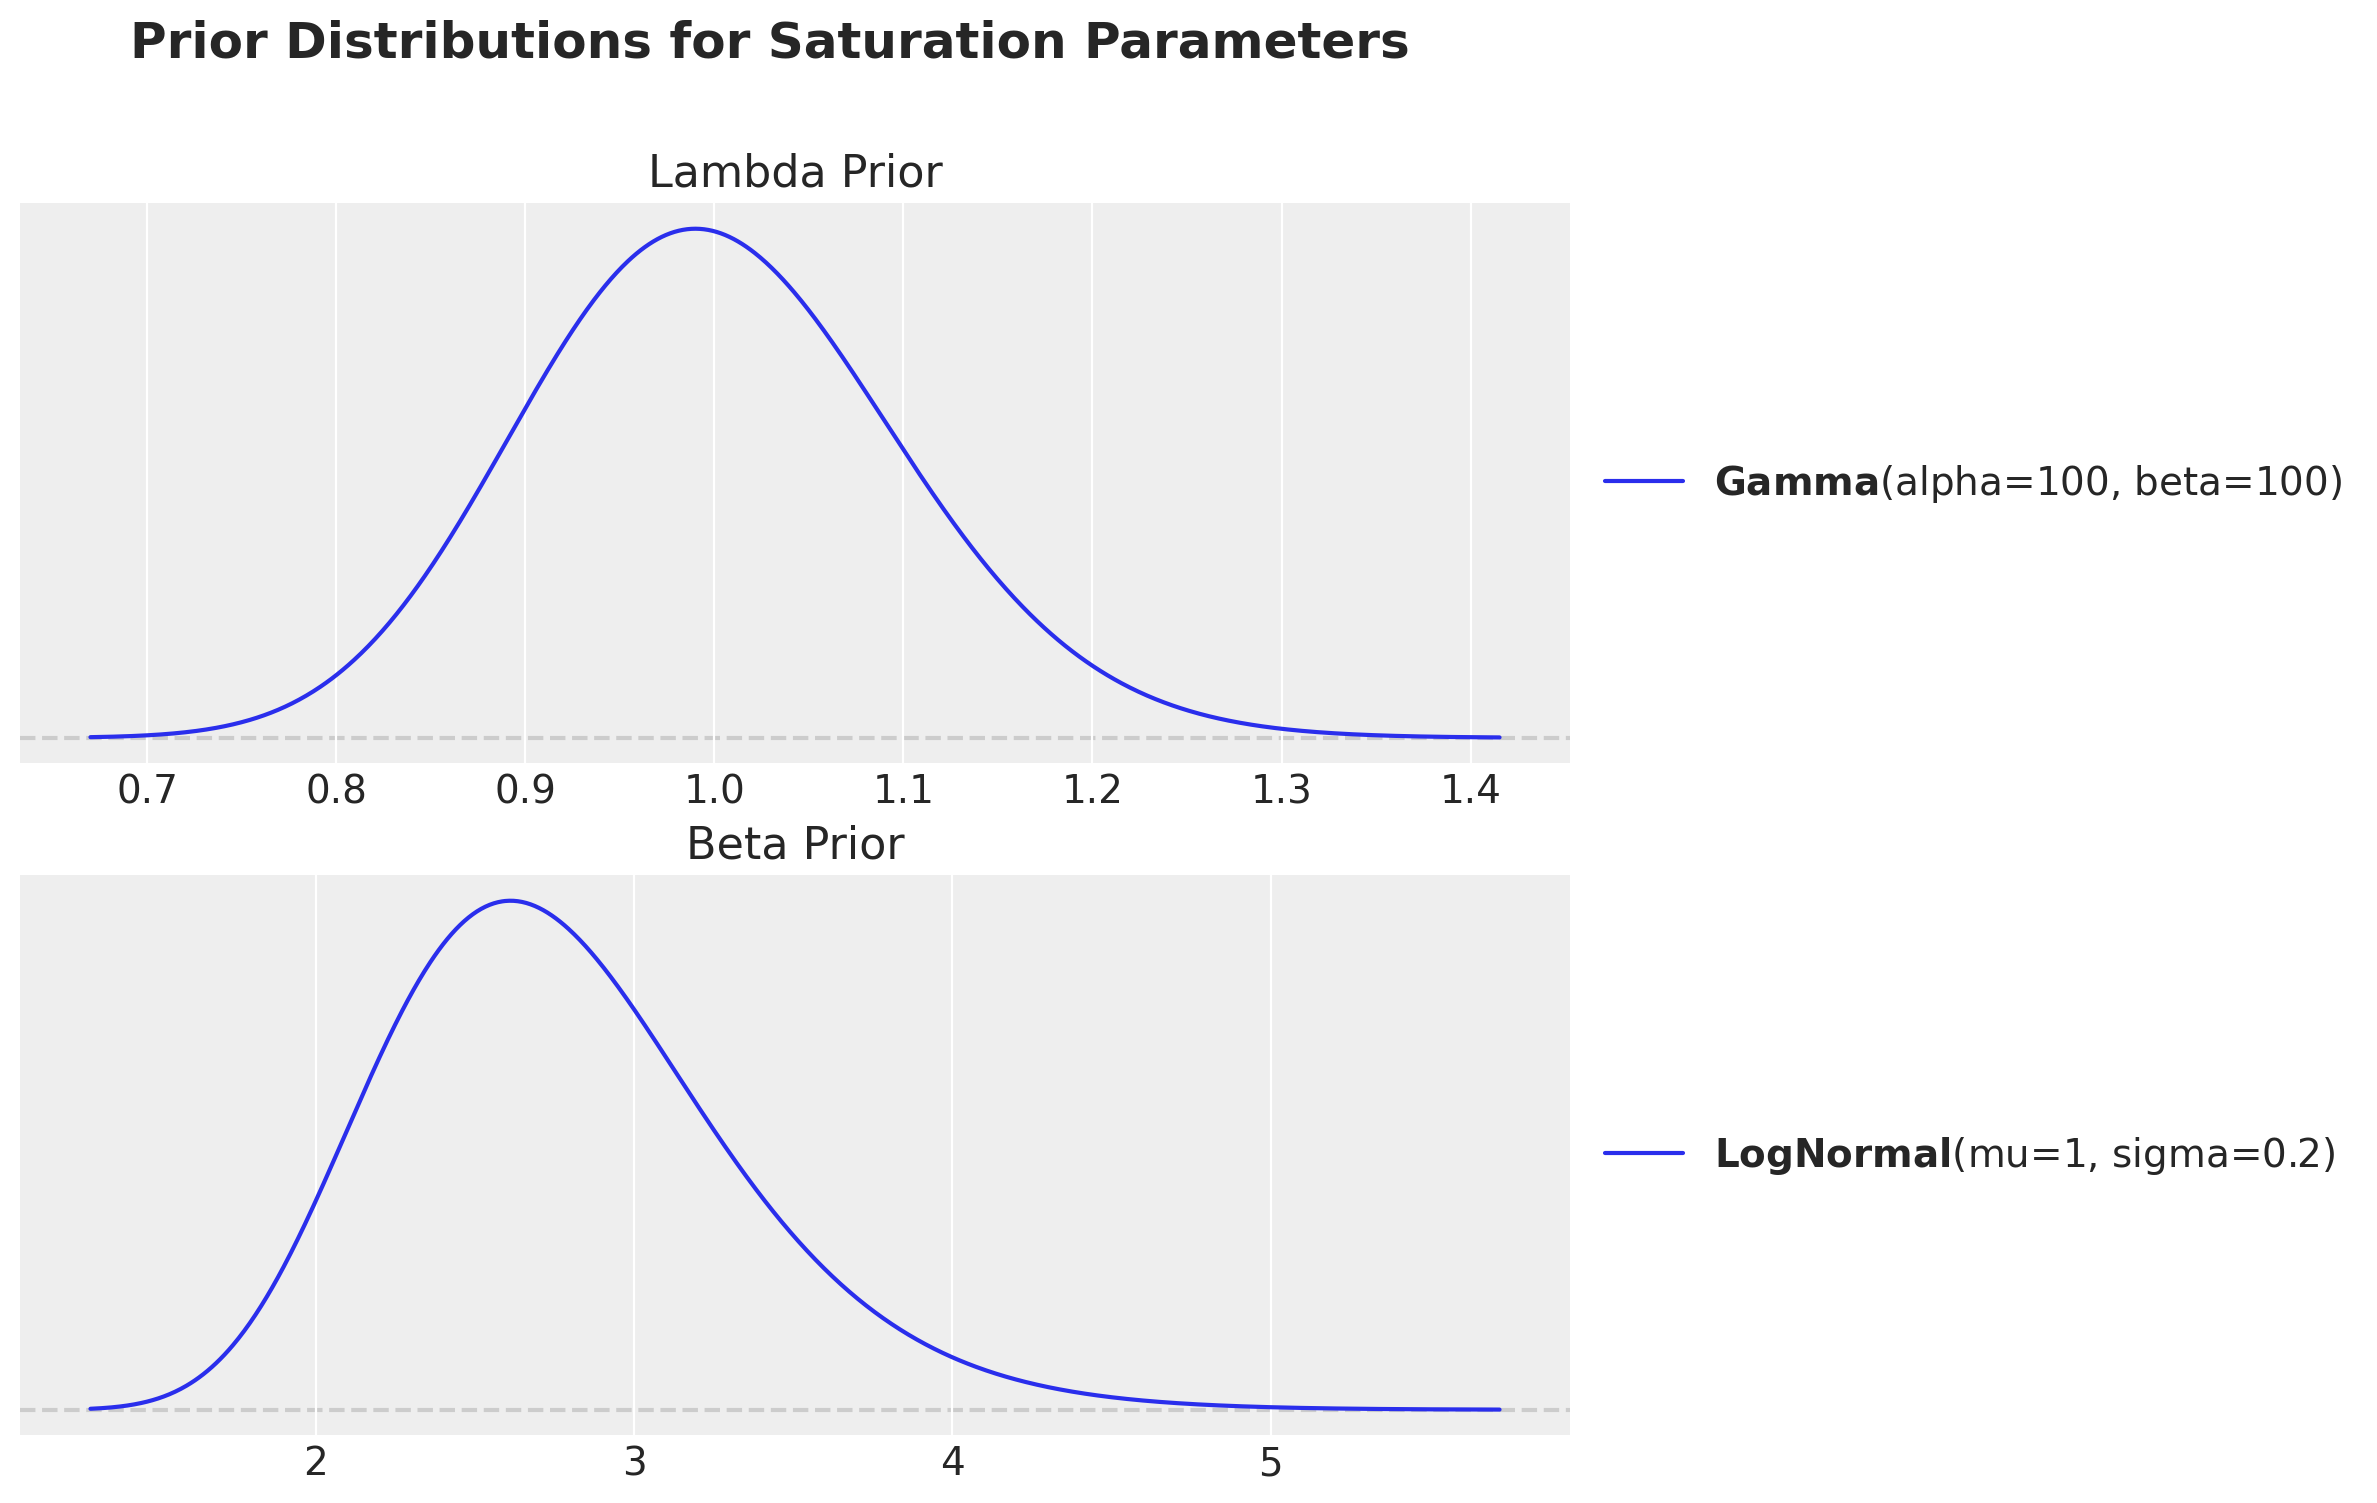

In [6]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 8),
    sharex=False,
    sharey=False,
    layout="constrained",
)

pz.Gamma(alpha=100, beta=100).plot_pdf(ax=ax[0])
ax[0].set(title="Lambda Prior")

pz.LogNormal(mu=1, sigma=0.2).plot_pdf(ax=ax[1])
ax[1].set(title="Beta Prior")

fig.suptitle(
    "Prior Distributions for Saturation Parameters", fontsize=18, fontweight="bold"
);

Sampling: [saturation_beta, saturation_lam]
Sampling: []


Output()

/var/folders/f0/rbz8xs8s17n3k3f_ccp31bvh0000gn/T/ipykernel_75791/4202441542.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


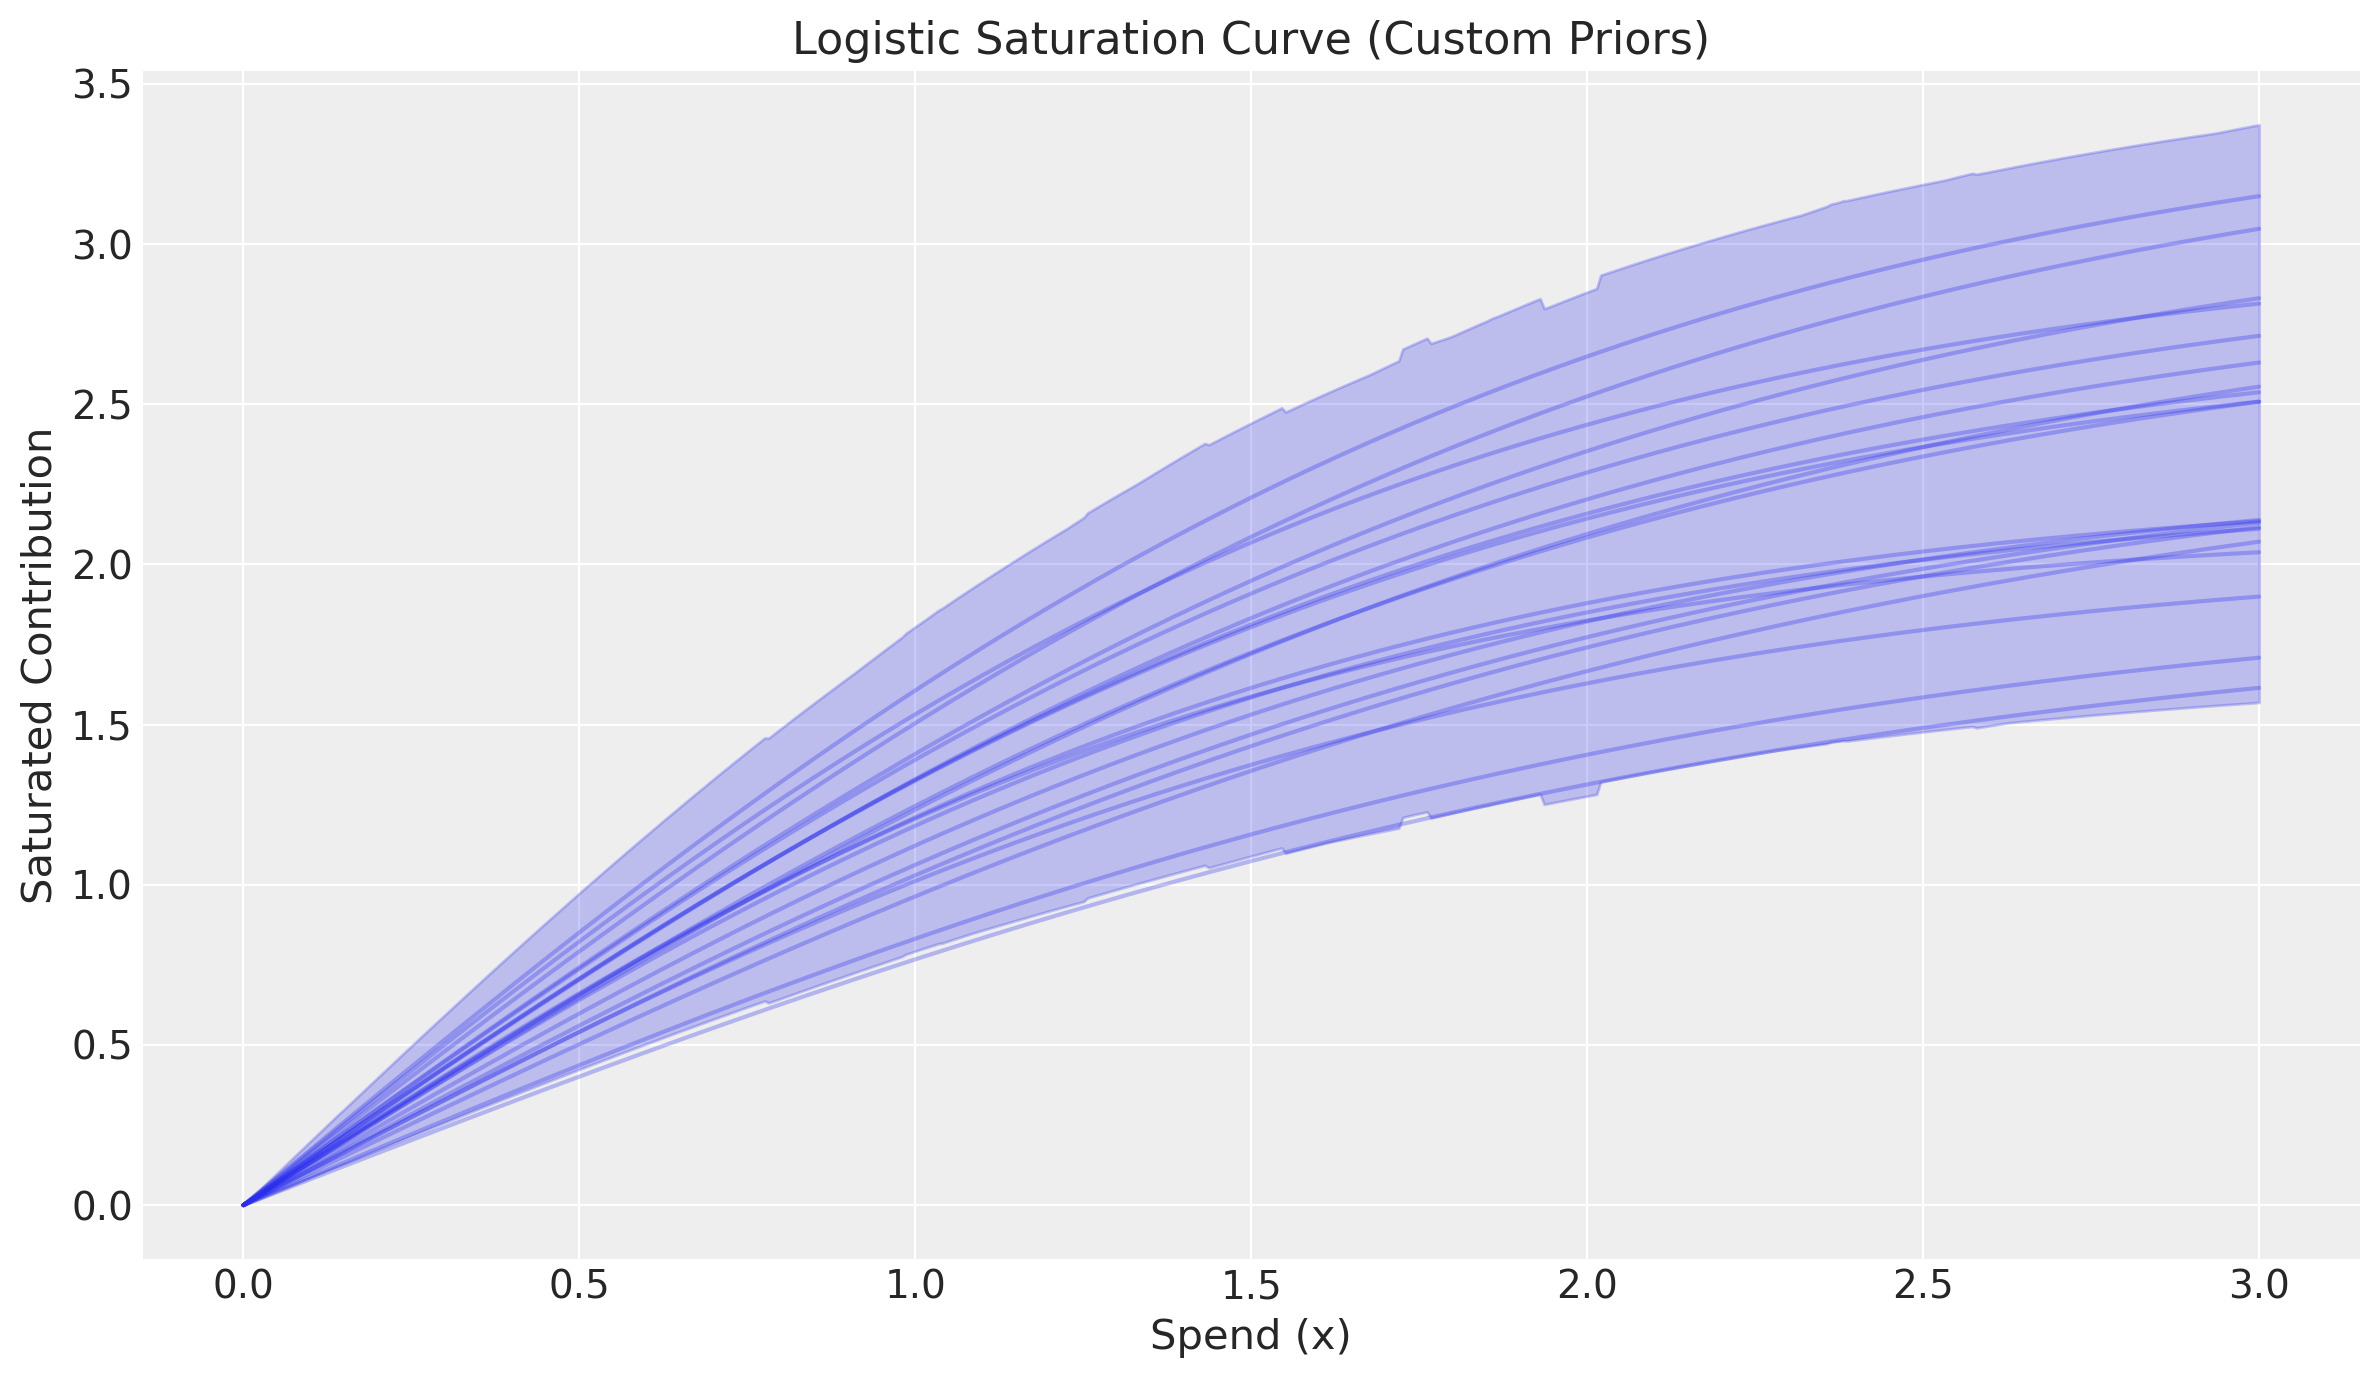

In [7]:
# Create a LogisticSaturation instance with default priors
saturation = LogisticSaturation(
    {
        "lam": Prior("Gamma", alpha=100, beta=100),
        "beta": Prior("LogNormal", mu=1, sigma=0.2),
    }
)

# Sample from the prior distributions
prior = saturation.sample_prior(random_seed=rng)

# Sample the saturation curve across a range of spend values
curve = saturation.sample_curve(prior, num_points=500, max_value=3)

# Plot the saturation curve with uncertainty (HDI and samples)
fig, axes = saturation.plot_curve(curve, n_samples=20, random_seed=rng)
axes[0].set(
    xlabel="Spend (x)",
    ylabel="Saturated Contribution",
    title="Logistic Saturation Curve (Custom Priors)",
)
plt.tight_layout()

We clearly see the samples are more concentrated around the mean.

We now see how these saturation curves are used in an MMM and how to extract business insights from them.

## Read Data

We use the same data as in the {ref}`mmm_multidimensional_example` tutorial.

In [8]:
data_path = data_dir / "mmm_multidimensional_example.csv"

data_df = pd.read_csv(data_path, parse_dates=["date"])
data_df.head(10)

,date,geo,x1,x2,event_1,event_2,y
0,2022-06-06,geo_a,5527.640078,0.000000,0,0,2647.596355
1,2022-06-06,geo_b,8849.257500,8063.918386,0,0,682.406280
2,2022-06-13,geo_a,6692.655692,0.000000,0,0,5020.823907
3,2022-06-13,geo_b,9073.817994,9354.014585,0,0,3753.104897
4,2022-06-20,geo_a,7124.016733,0.000000,0,0,6184.322132
5,2022-06-20,geo_b,7867.854558,5608.112521,0,0,3329.279953
6,2022-06-27,geo_a,7725.169902,0.000000,0,0,5446.374631
7,2022-06-27,geo_b,9712.332359,11760.981800,0,0,7544.192188
8,2022-07-04,geo_a,8545.792935,0.000000,0,0,10058.970814
9,2022-07-04,geo_b,6747.884370,6774.114961,0,0,2359.259385


Let's visualize the spend and sales data for each channel and geography.

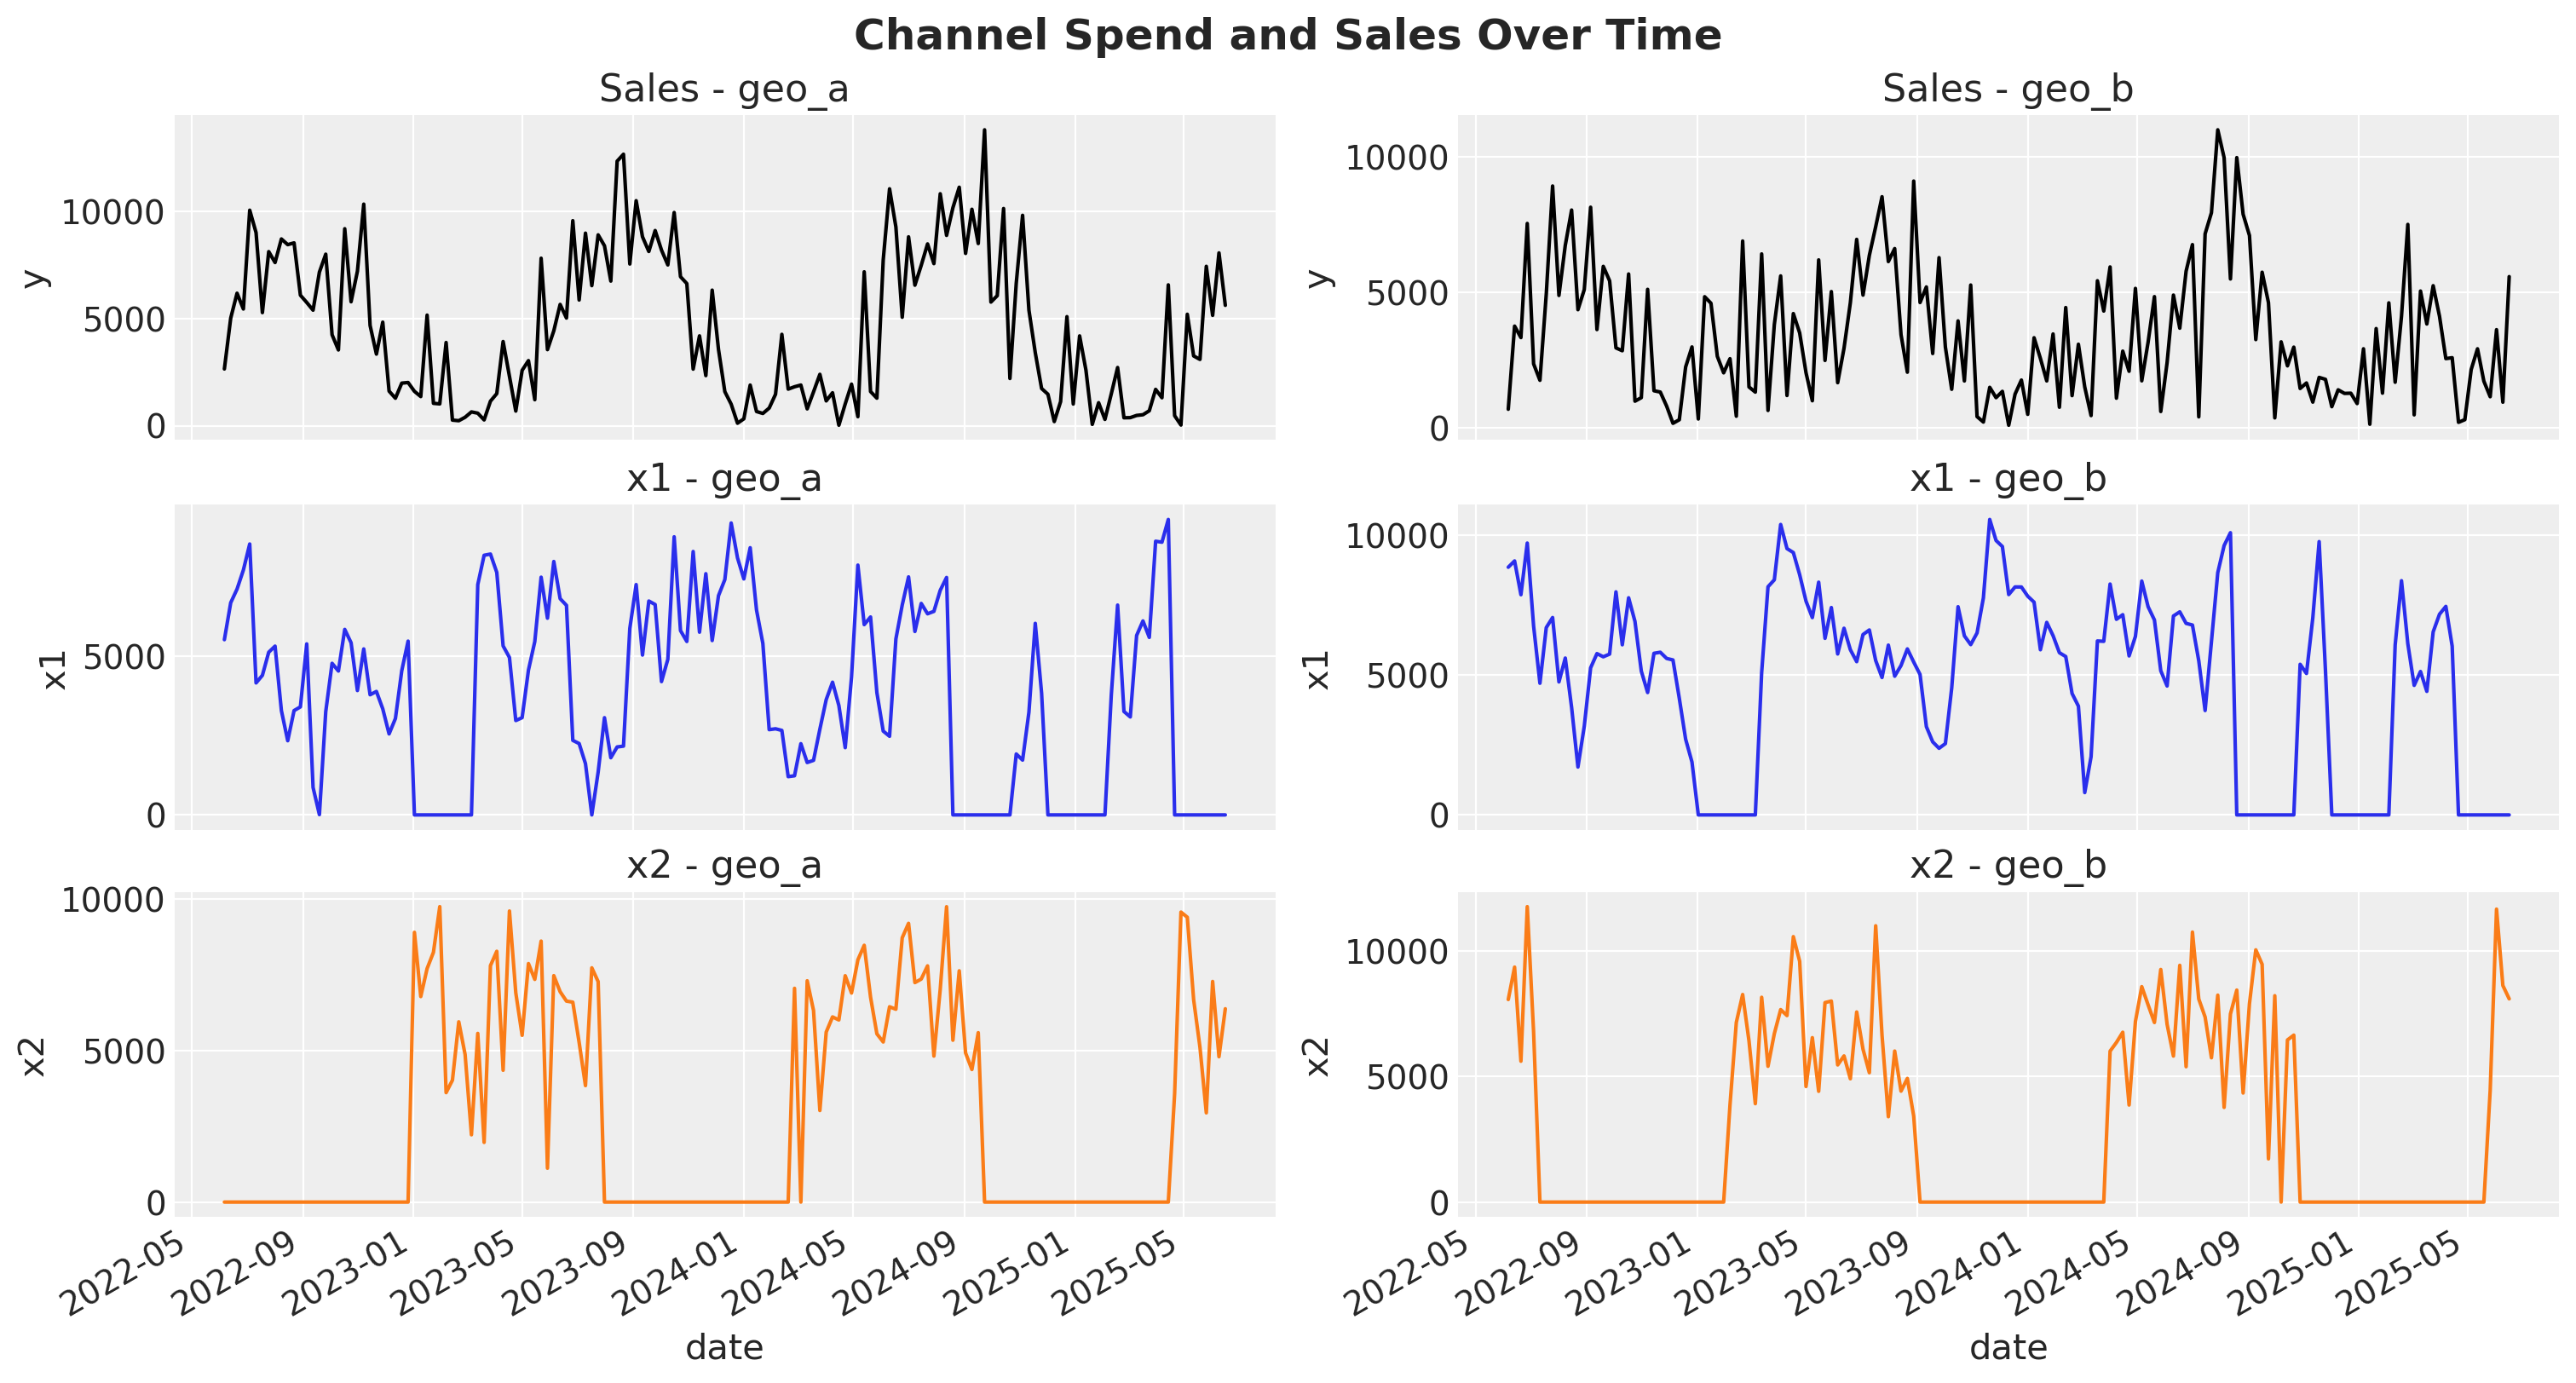

In [9]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(15, 8),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for i, geo in enumerate(["geo_a", "geo_b"]):
    geo_data = data_df.query("geo == @geo")

    for j, channel in enumerate(["x1", "x2"]):
        sns.lineplot(
            x=geo_data["date"],
            y=geo_data[channel],
            color=f"C{j}",
            ax=axes[j + 1, i],
        )
        axes[j + 1, i].set_title(f"{channel} - {geo}")

    sns.lineplot(
        x=geo_data["date"],
        y=geo_data["y"],
        color="black",
        ax=axes[0, i],
    )
    axes[0, i].set_title(f"Sales - {geo}")

fig.autofmt_xdate()
fig.suptitle("Channel Spend and Sales Over Time", fontsize=18, fontweight="bold");

Let's compute the spend share for each channel and geography.

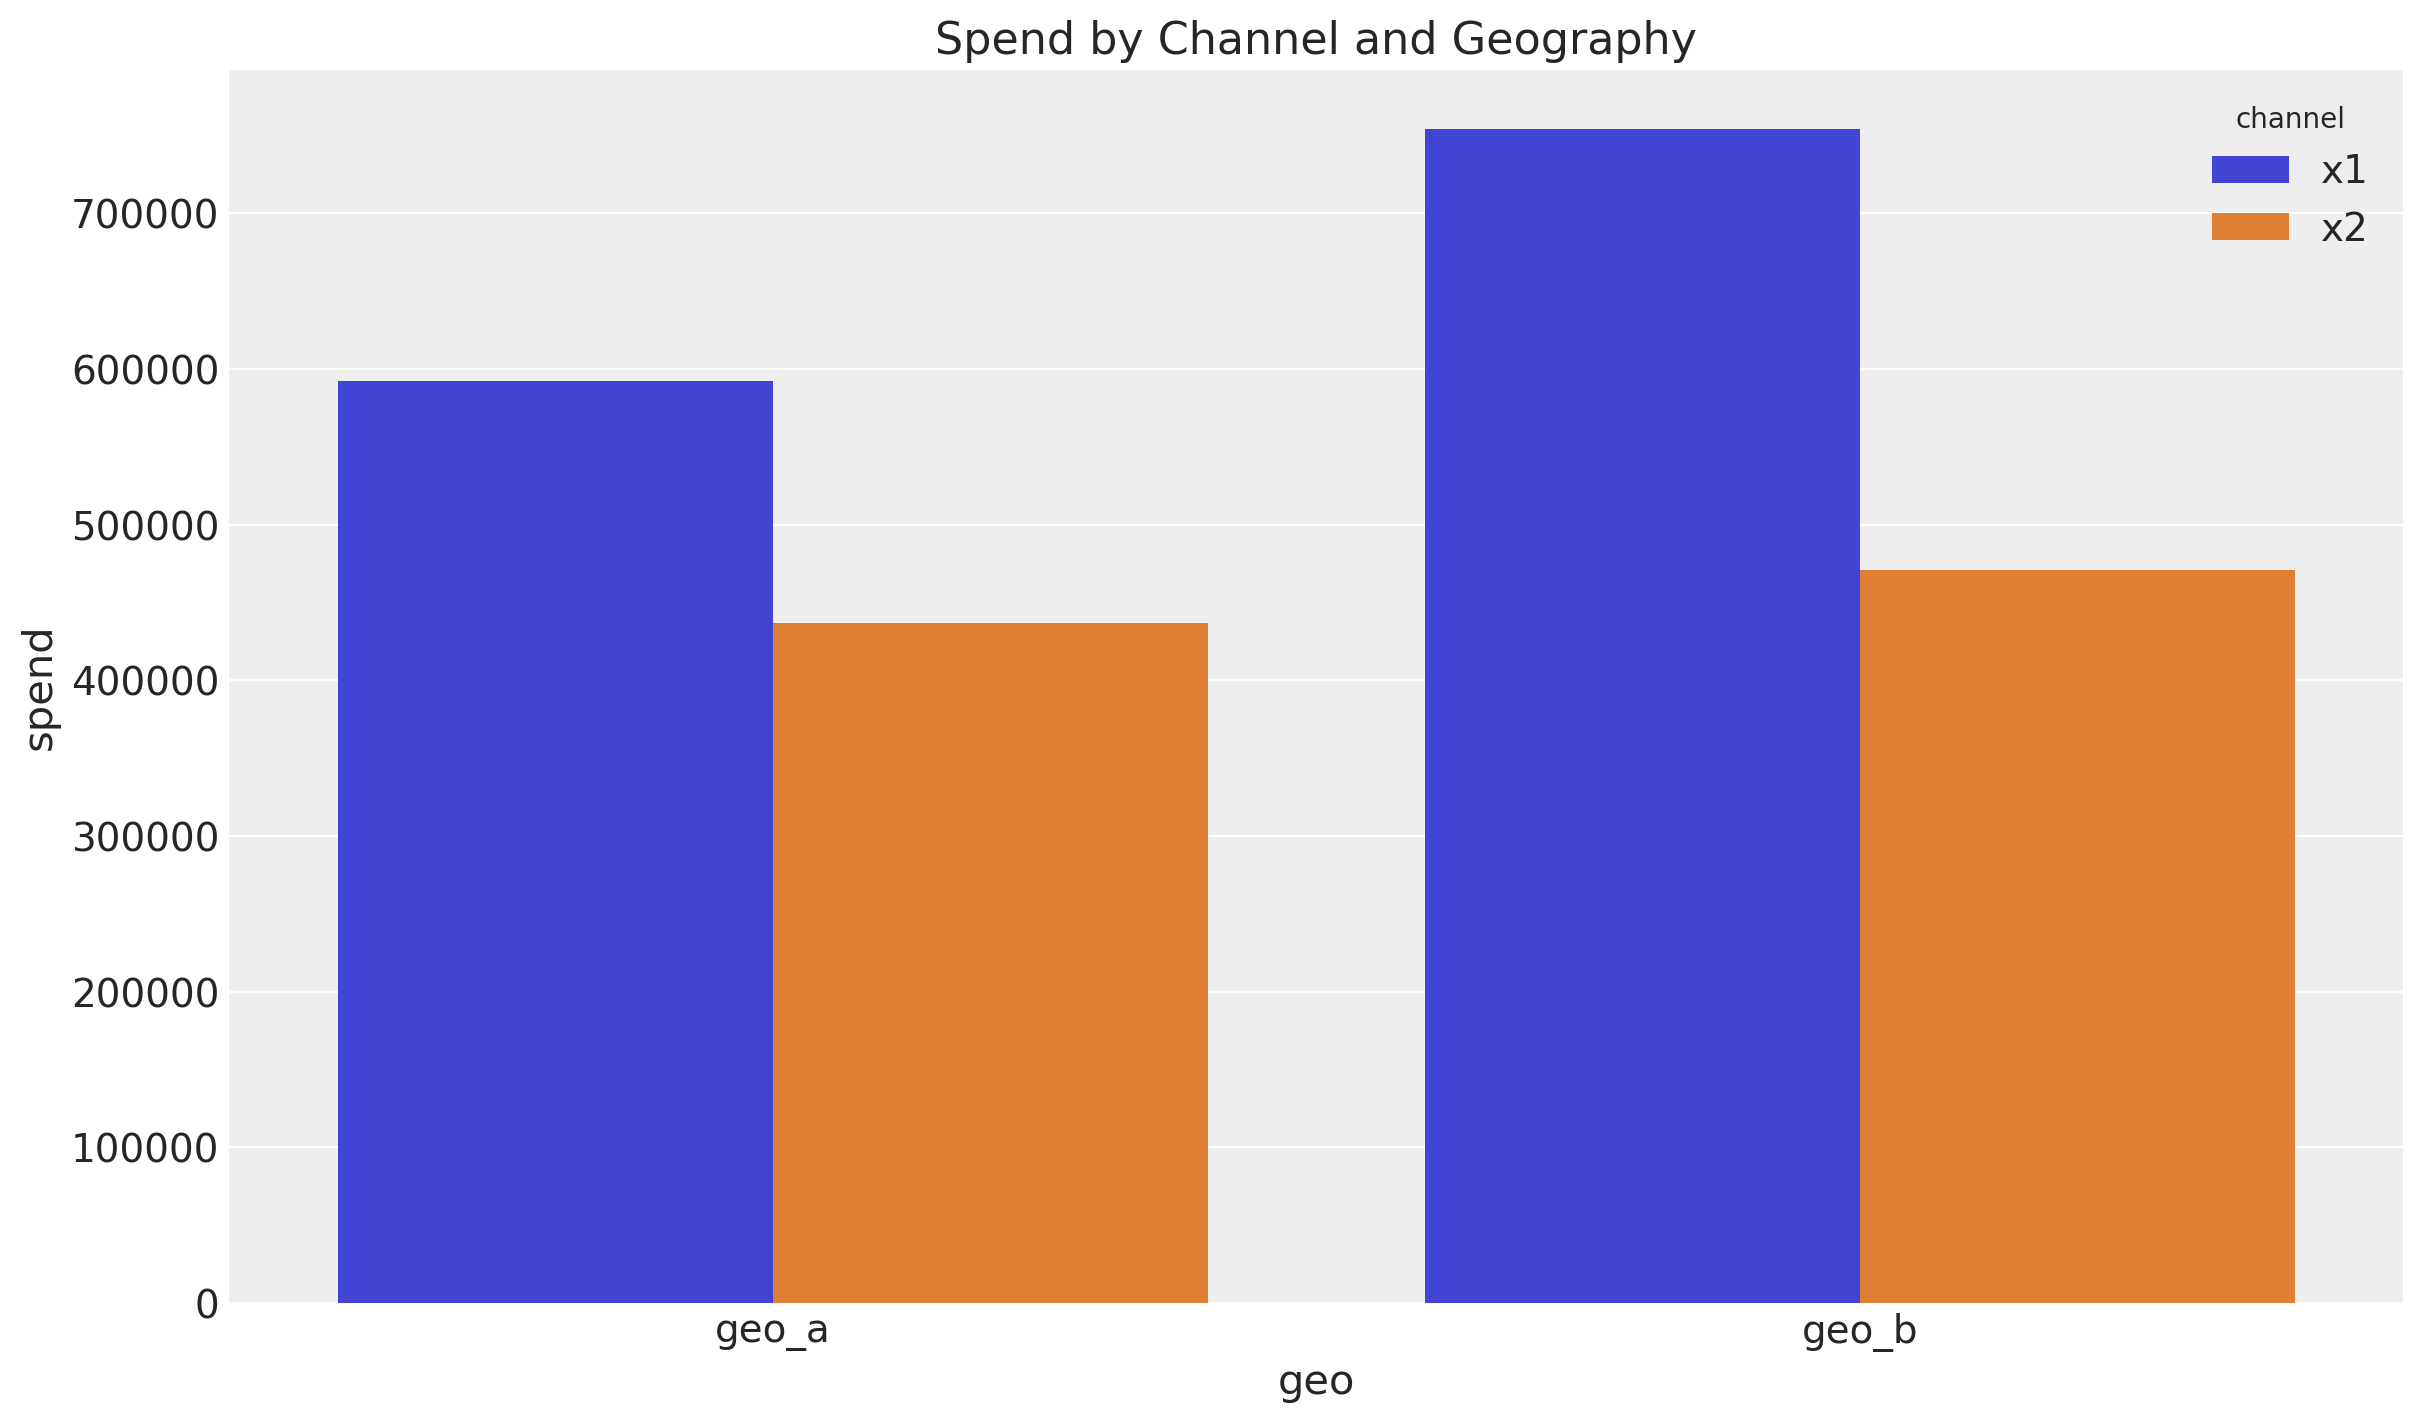

In [10]:
fig, ax = plt.subplots()
(
    data_df.melt(
        id_vars=["geo", "date"],
        value_vars=["x1", "x2"],
        var_name="channel",
        value_name="spend",
    )
    .groupby(["geo", "channel"], as_index=False)
    .agg({"spend": "sum"})
    .pipe((sns.barplot, "data"), x="geo", y="spend", hue="channel", ax=ax)
)
ax.set_title("Spend by Channel and Geography");

## Model Specification and Fitting

We'll fit a multi-dimensional MMM with:
- **Geometric Adstock**: Models the carry-over effect of advertising
- **Logistic Saturation**: Models diminishing returns as spend increases

For simplicity, we use a streamlined model configuration.

In [11]:
# Define adstock and saturation transformations
adstock = GeometricAdstock(
    priors={"alpha": Prior("Beta", alpha=2, beta=5, dims=("geo", "channel"))},
    l_max=8,
)

saturation = LogisticSaturation(
    priors={
        "beta": Prior("Gamma", mu=0.3, sigma=0.15, dims=("geo", "channel")),
        "lam": Prior("Gamma", mu=0.5, sigma=0.25, dims="channel"),
    }
)

# Model configuration
model_config = {
    "intercept": Prior("Gamma", mu=0.5, sigma=0.25, dims="geo"),
    "gamma_control": Prior("Normal", mu=0, sigma=0.5, dims="control"),
    "likelihood": Prior(
        "TruncatedNormal",
        lower=0,
        sigma=Prior("HalfNormal", sigma=1.5),
        dims=("date", "geo"),
    ),
}

# Create the MMM instance
mmm = MMM(
    date_column="date",
    target_column="y",
    channel_columns=["x1", "x2"],
    control_columns=["event_1", "event_2"],
    dims=("geo",),
    scaling={
        "channel": {"method": "max", "dims": ()},
        "target": {"method": "max", "dims": ()},
    },
    adstock=adstock,
    saturation=saturation,
    yearly_seasonality=2,
    model_config=model_config,
)

Now we fit the model.

In [13]:
# Prepare training data
x_train = data_df.drop(columns=["y"])
y_train = data_df["y"]

# Build and fit the model
mmm.build_model(X=x_train, y=y_train)

# Add original scale contribution variables (needed for original_scale=True in plots)
mmm.add_original_scale_contribution_variable(var=["channel_contribution", "y"])

sample_kwargs = {
    "draws": 1_500,
    "tune": 1_000,
    "chains": 4,
    "target_accept": 0.95,
    # "nuts_sampler": "nutpie",
    "random_seed": rng,
}

# Fit the model
mmm.fit(
    X=x_train,
    y=y_train,
    **sample_kwargs,
)

# Sample posterior predictive
_ = mmm.sample_posterior_predictive(X=x_train, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 9 seconds.


Output()

Sampling: [y]


Output()

In [14]:
# Quick check of model diagnostics
print(f"Divergences: {mmm.idata.sample_stats.diverging.sum().values}")

Divergences: 0


We have no divergences!

We can continue by looking into the aggregated contribution posterior of each channel.

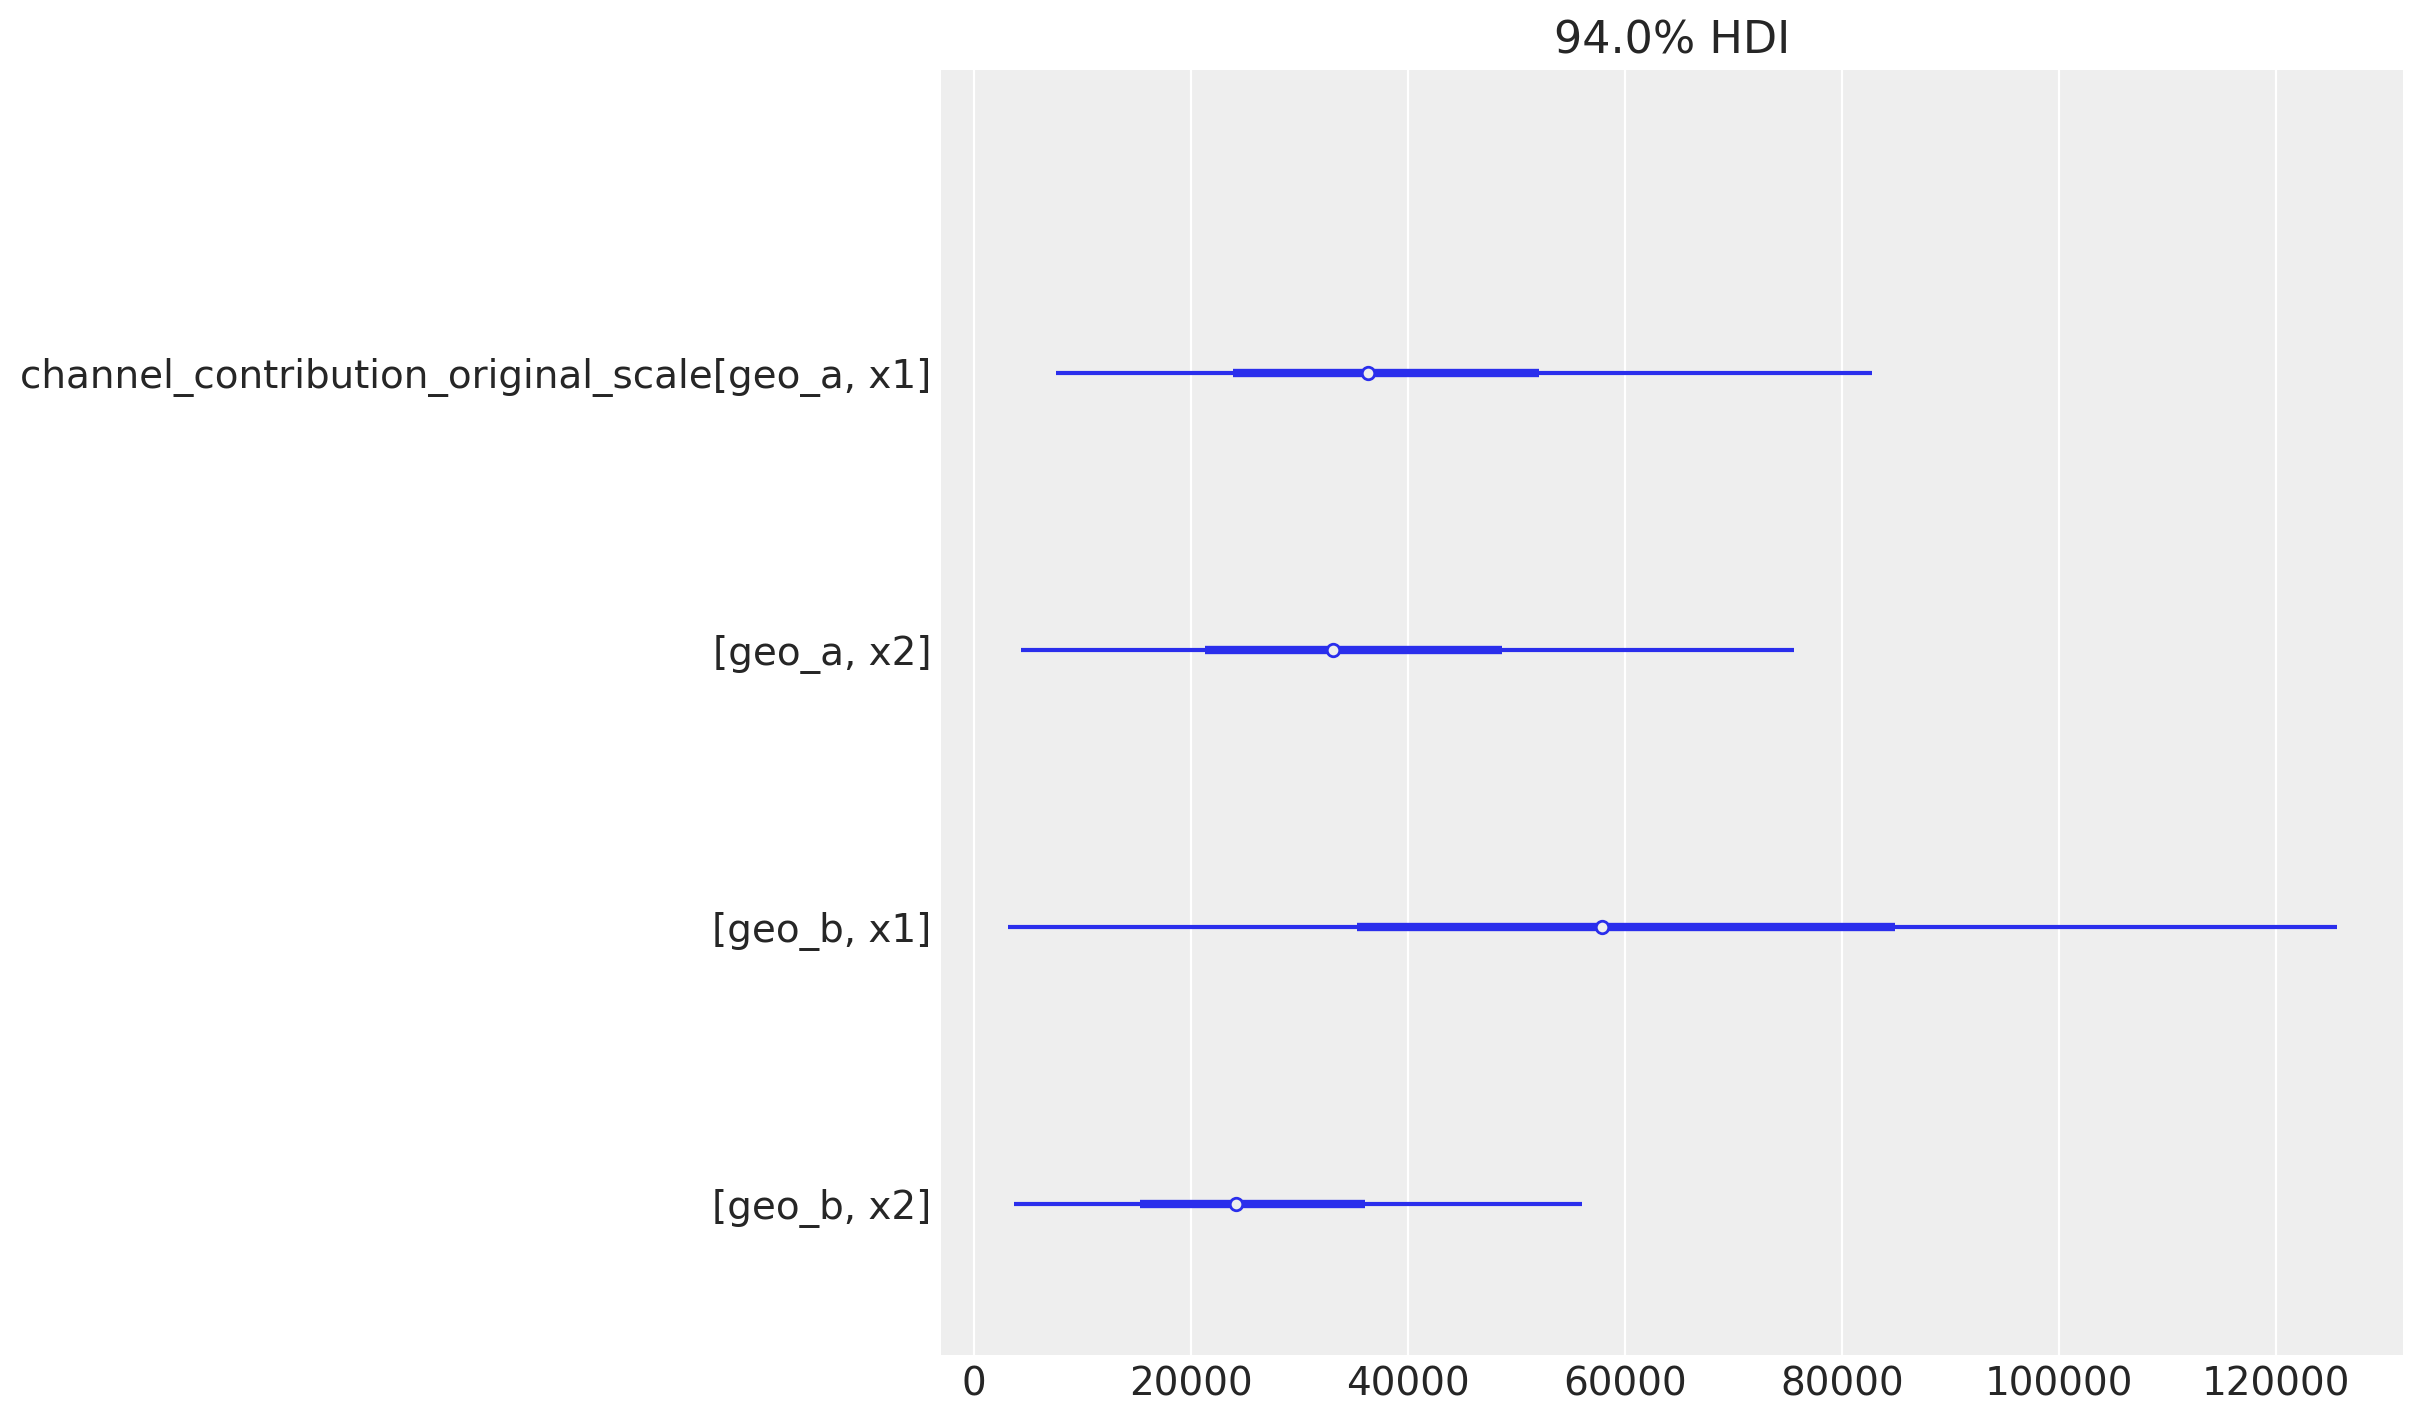

In [15]:
fig, ax = plt.subplots()

az.plot_forest(
    mmm.fit_result["channel_contribution_original_scale"].sum(dim="date"),
    combined=True,
    ax=ax,
);

For Geo A, we see that the contribution of $x_1$ and $x_2$ are comparable whereas for Geo B, $x_1$ has a much higher contribution than $x_2$.

This is a great start, but we want to understand better these contributions and how they are related by the current spend levels.

## Visualization 1: Direct/Marginal Contribution 

The `saturation_scatterplot` shows the **direct relationship between spend and contribution at each time point**. This visualization answers the question:

> *"Given a specific spend level, what is the direct contribution to sales?"*

Each point in this plot represents a single observation (one time period), showing:
- **X-axis**: Channel spend at that time point
- **Y-axis**: Direct contribution to sales at that time point

/var/folders/f0/rbz8xs8s17n3k3f_ccp31bvh0000gn/T/ipykernel_75791/1864980976.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


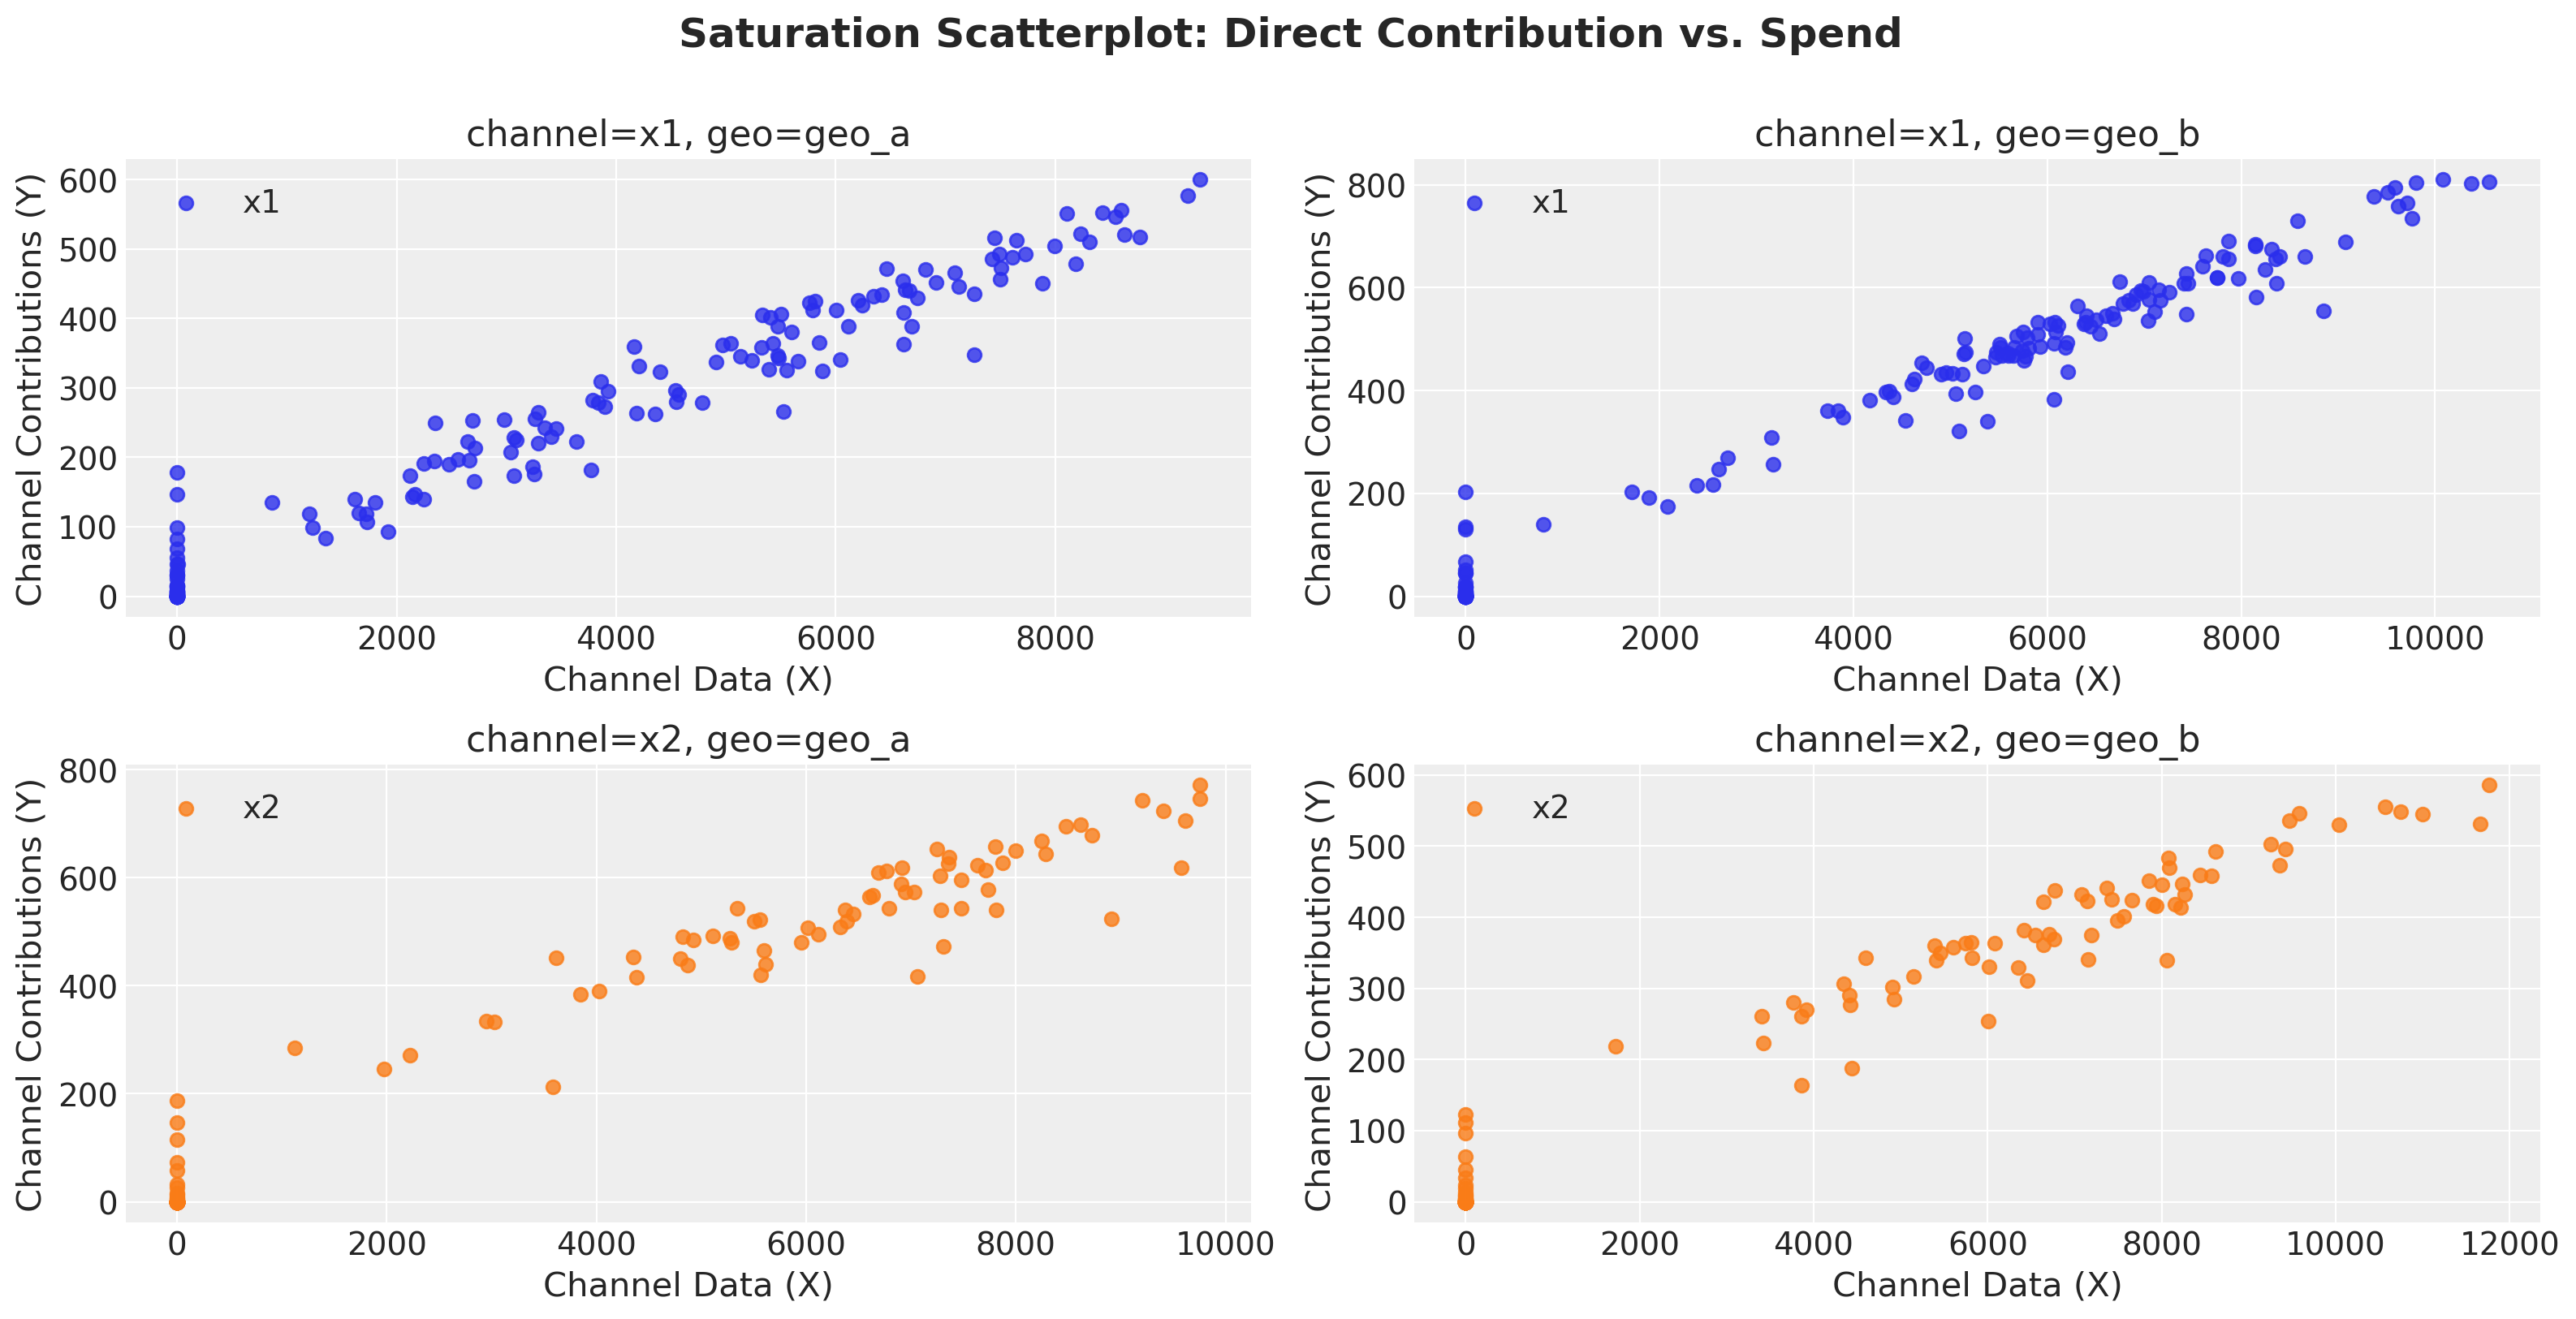

In [16]:
fig, axes = mmm.plot.saturation_scatterplot(
    width_per_col=8,
    height_per_row=4,
    original_scale=True,
)
fig.suptitle(
    "Saturation Scatterplot: Direct Contribution vs. Spend",
    fontsize=18,
    fontweight="bold",
    y=1.01,
)
plt.tight_layout()

**How to interpret this plot:**

1. **Shape of the curve**: The fitted line shows how contribution increases with spend, with diminishing returns visible as the curve flattens at higher spend levels.

2. **Scatter points**: Each point represents a specific date's spend-contribution pair. 

```{note}
This plot shows the **instantaneous/marginal** relationship. It tells you "if I spend X on a given day, I expect Y contribution on that day."

The reason you see non-zero contribution even at zero spend is because of the adstock effect.
```

## Visualization 2: Total Contribution over Spend Share 

The `sensitivity_analysis` shows how **total contribution (summed over all time periods)** changes as you scale overall spend. This visualization answers the question:

> *"If I increase/decrease my total budget by X%, what is the total impact on sales?"*

This is a **counterfactual analysis**: we ask "what would have happened if we had spent more or less?"

In [17]:
# Here we set scenarios to sweep over
# a 10% to 200% of the historical spend.
sweeps = np.linspace(0.1, 2.0, 100)
mmm.sensitivity.run_sweep(
    sweep_values=sweeps,
    var_input="channel_data",
    var_names="channel_contribution_original_scale",
    extend_idata=True,  # it could be false and you save the object
)

/Users/carlostrujillo/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/sensitivity_analysis.py:146: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  draws = int(self.idata.posterior.dims.get("draw", 0))
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Let's plot the results:

/Users/carlostrujillo/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/plot.py:2520: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


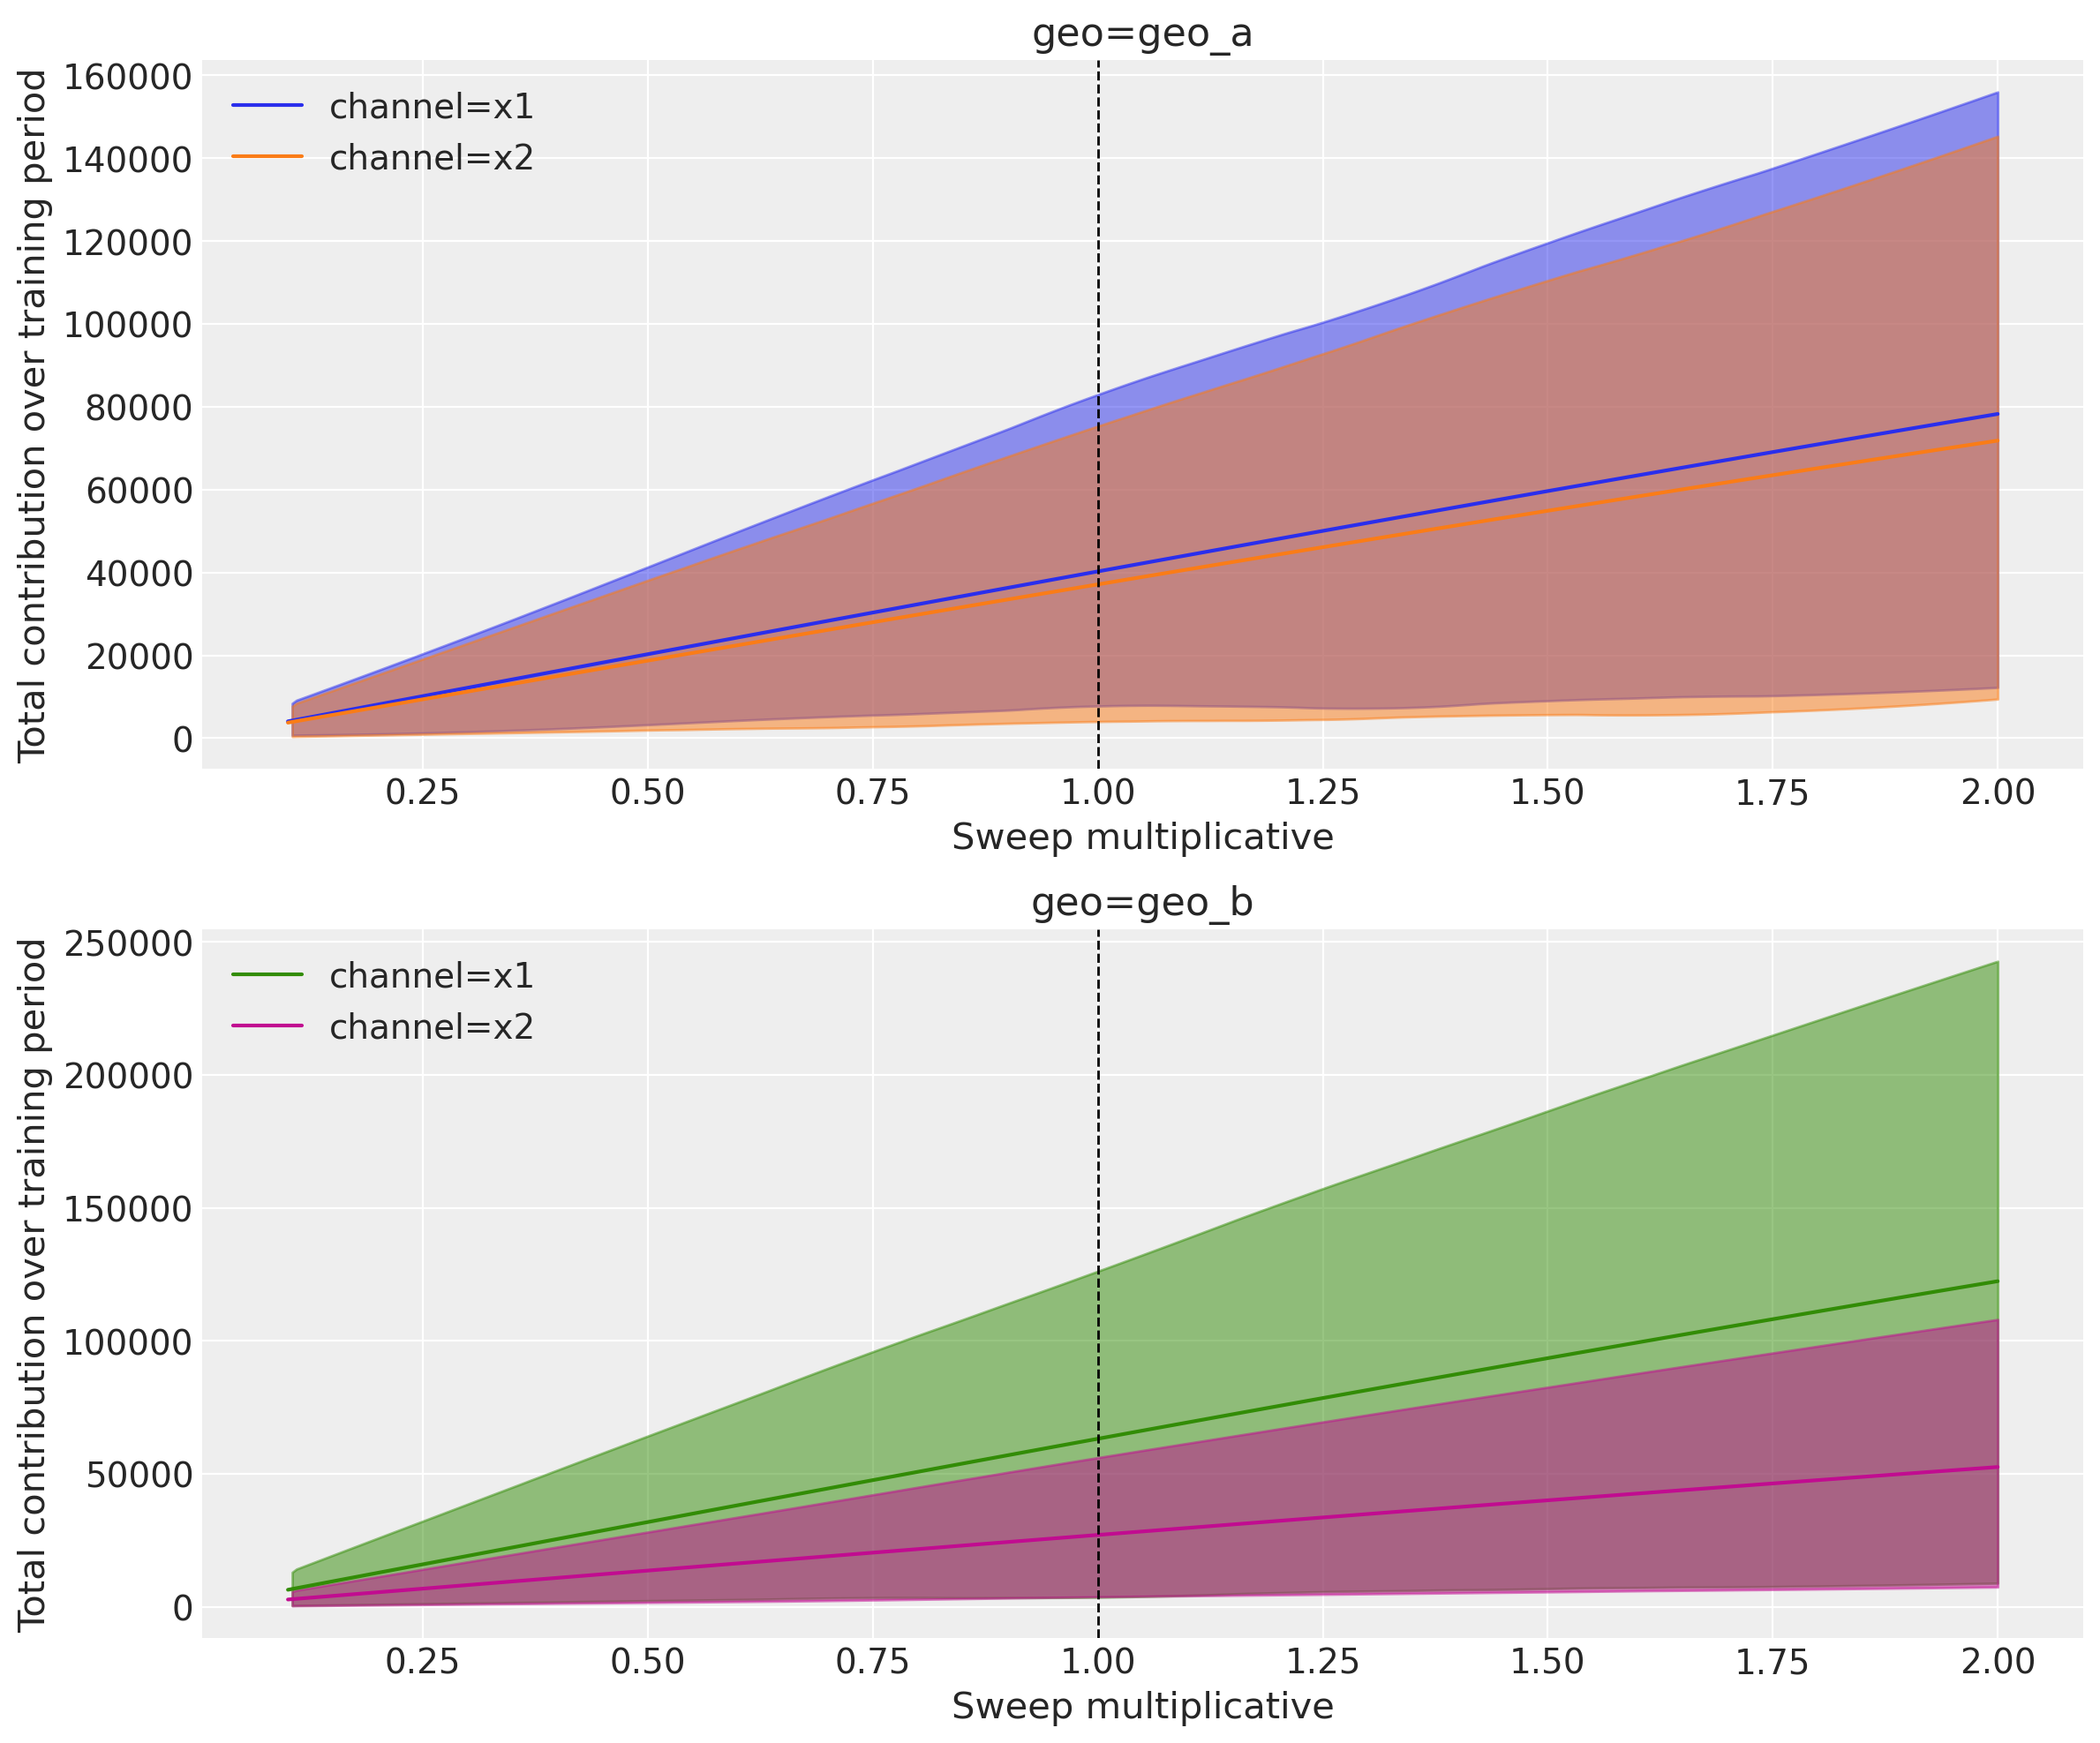

In [18]:
fig, axes = mmm.plot.sensitivity_analysis(
    xlabel="Sweep multiplicative",
    ylabel="Total contribution over training period",
    hue_dim="channel",
    subplot_kwargs={"nrows": 2, "figsize": (12, 10)},
)

for ax in axes.flat:
    ax.axvline(1.0, color="black", linestyle="--", linewidth=1)

**How to interpret this plot:**

1. **X-axis (sweep multiplicative)**: The spend multiplier. A value of 1.0 represents the actual historical spend, 0.5 means half the spend, and 2.0 means double the spend.

2. **Y-axis (Total Contribution)**: The sum of contributions across all time periods in the dataset.

3. **Vertical line at sweep=1**: This marks the current/historical spend level.

4. **HDI bands**: Show the uncertainty in total contribution at each spend level.

5. **Curve shape**: 
   - Steep slope at low sweep → High marginal returns (you're not yet saturated)
   - Flattening slope at high sweep → Diminishing returns (approaching saturation)

```{important}
This plot shows the **global/total** relationship. It tells you "across the entire time period, if I had scaled all my spend by factor "sweep", my total contribution would be Y."
```

Observe, that these results are consistent with the initial total copntribution analysis: For Geo A, $x_1$ and $x_2$ have similar contributions, but for Geo B, $x_1$ has a much higher contribution than $x_2$ (at the current spend levels).

## Advanced Usage 

The `plot.sensitivity_analysis` method supports several advanced options for customization.

### Using Absolute X-Axis

Instead of showing the sweep multiplier on the x-axis, you can display absolute spend values using `x_sweep_axis="absolute"`. This multiplies the sweep values by the `channel_scale` for each channel, so each line shows its actual spend range.

**Note:** When using `x_sweep_axis="absolute"`:
- Each channel will have its own X-axis range based on its scale factor
- For example, if channel A has scale 500K and channel B has scale 2M, at sweep=2x:
  - Channel A shows values up to 1M (500K x 2)
  - Channel B shows values up to 4M (2M x 2)
- This is useful for seeing actual spend values rather than relative multipliers
- Requires `hue_dim` to be set (typically "channel")

Let's first examine the sensitivity analysis data structure:

/Users/carlostrujillo/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/plot.py:2520: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


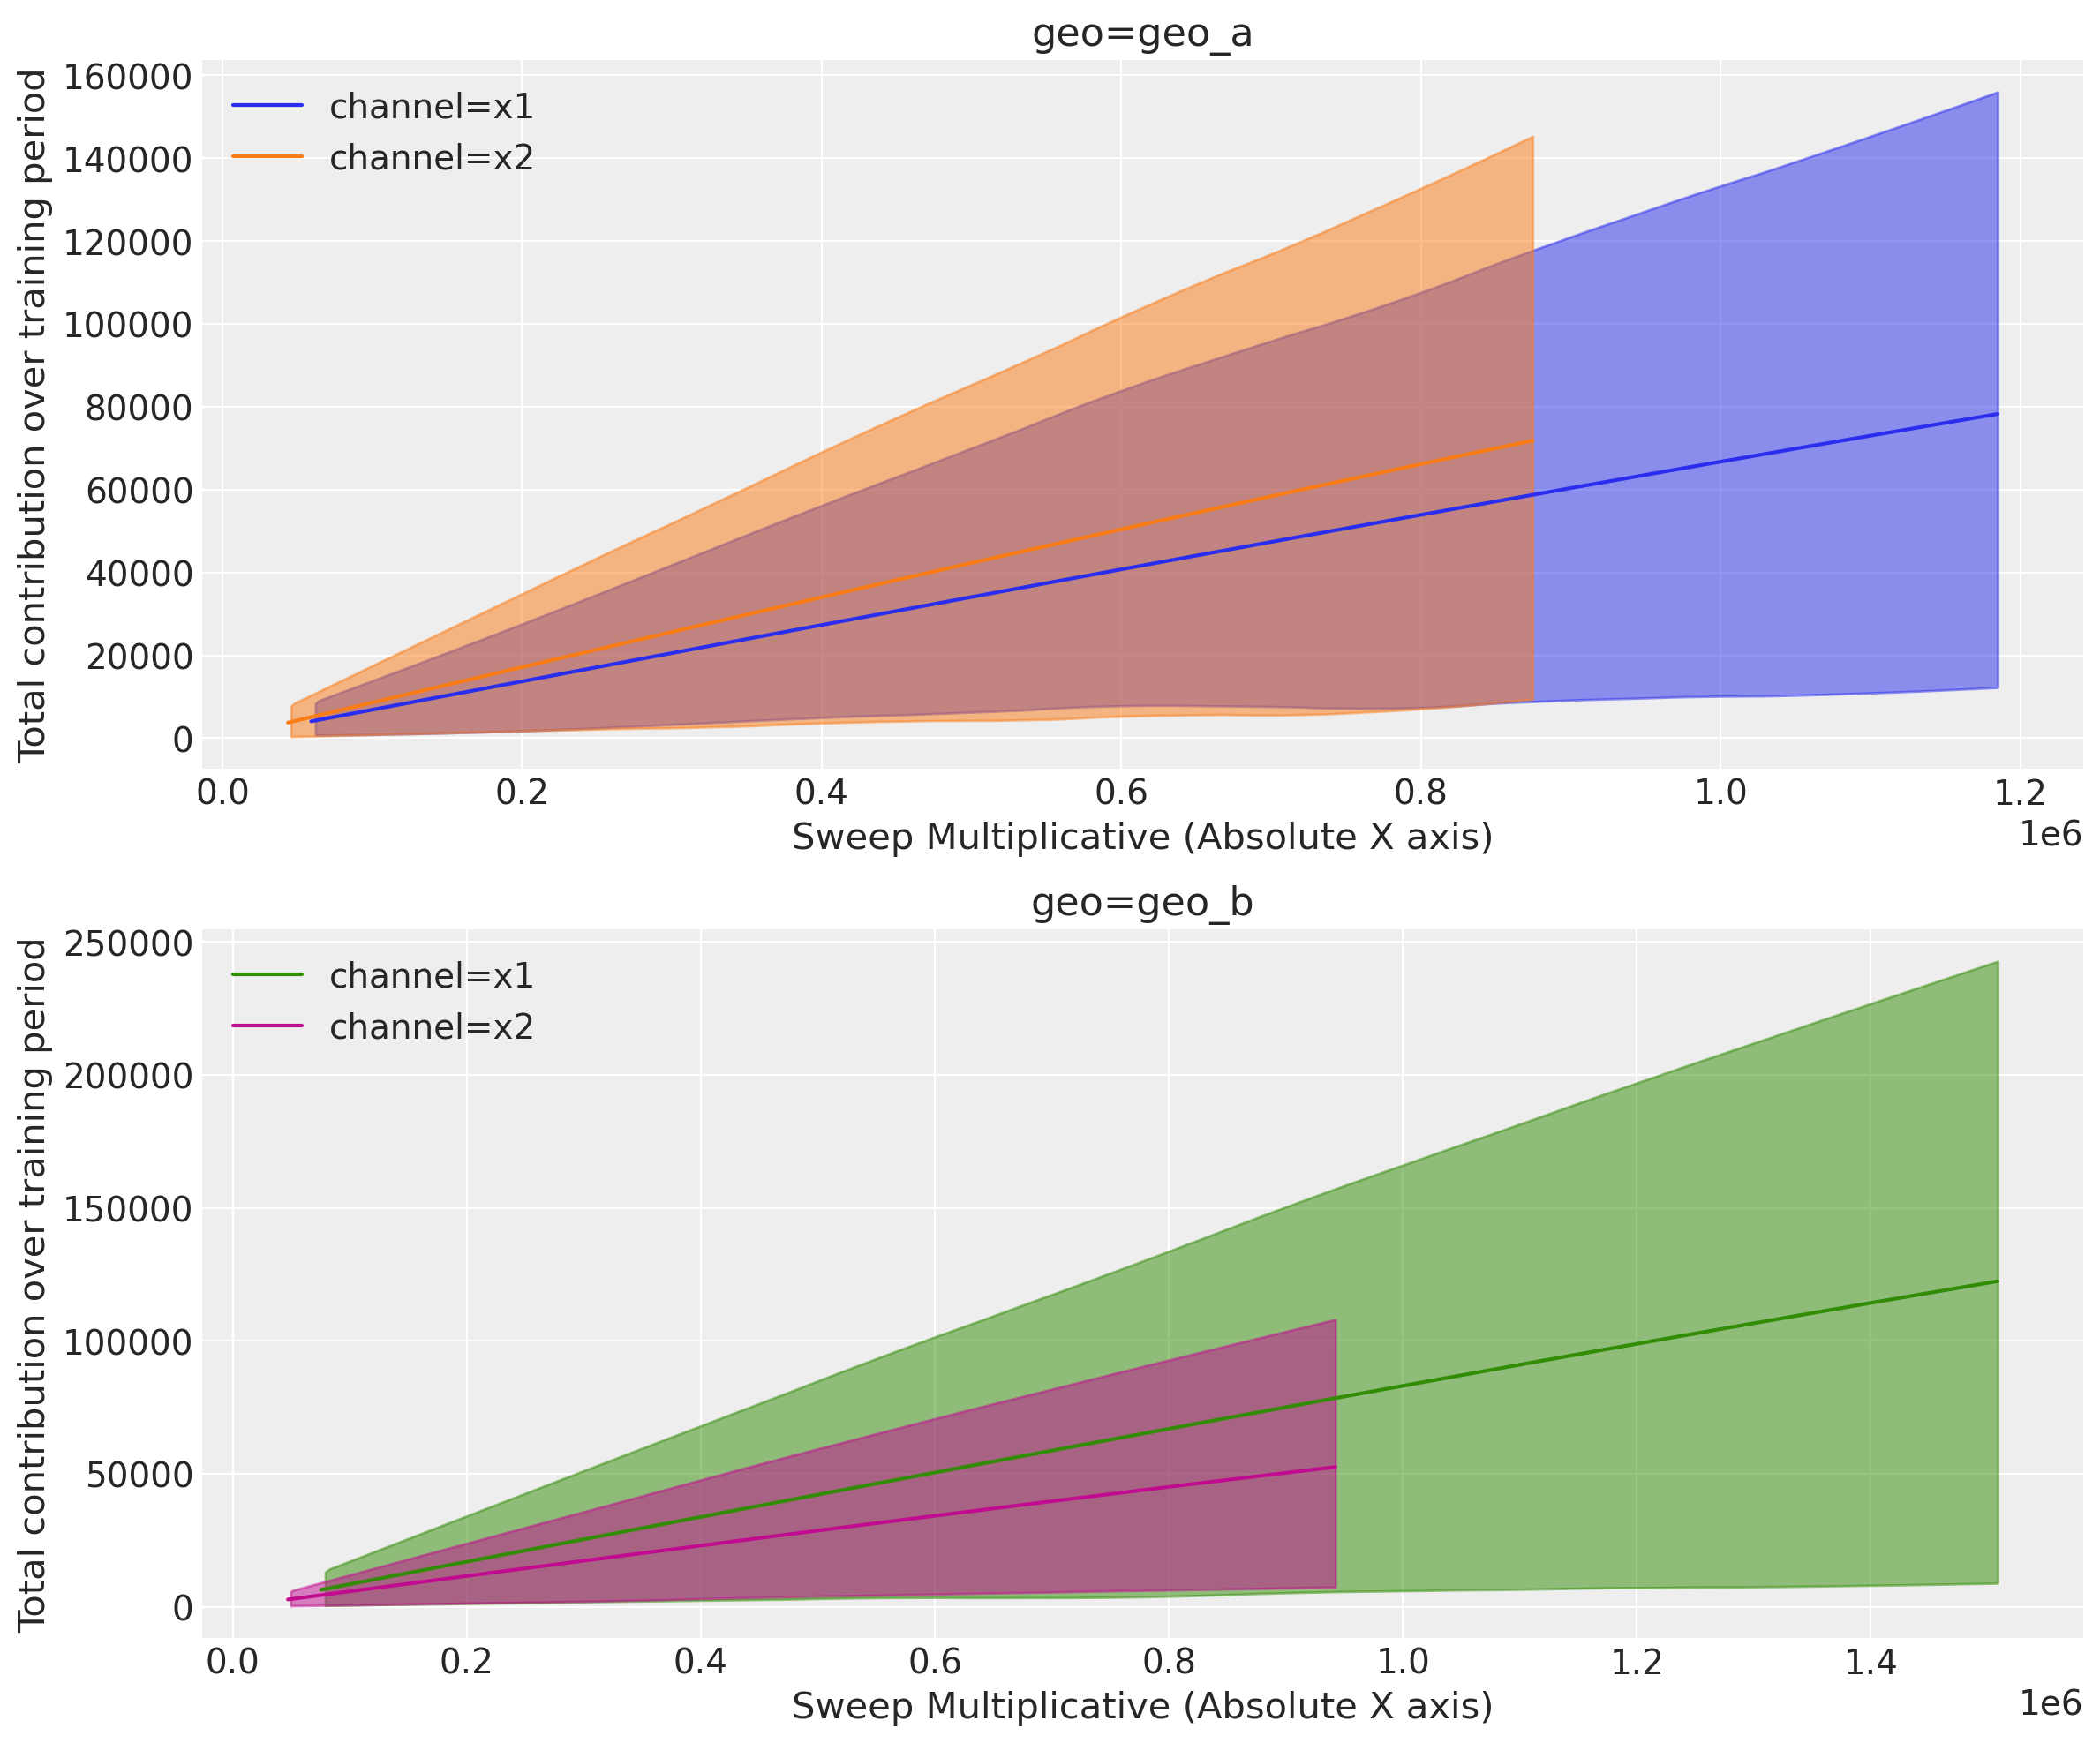

In [19]:
fig, axes = mmm.plot.sensitivity_analysis(
    xlabel="Sweep Multiplicative (Absolute X axis)",
    ylabel="Total contribution over training period",
    hue_dim="channel",
    x_sweep_axis="absolute",
    subplot_kwargs={"nrows": 2, "figsize": (12, 10)},
)

With `x_sweep_axis="absolute"`:
- The x-axis shows actual spend values (sweep multiplier x channel_scale)
- Each channel has its own x-axis range based on its scale factor
- This view is more intuitive for budget discussions ("If we spend X total, we get Y contribution")
- Note: Lines may end at different x-values since channels have different scales

### Filtering by Geography

We can use [`xarray`](https://docs.xarray.dev/en/stable/)'s API to filter by geography.

/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.12/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.12/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


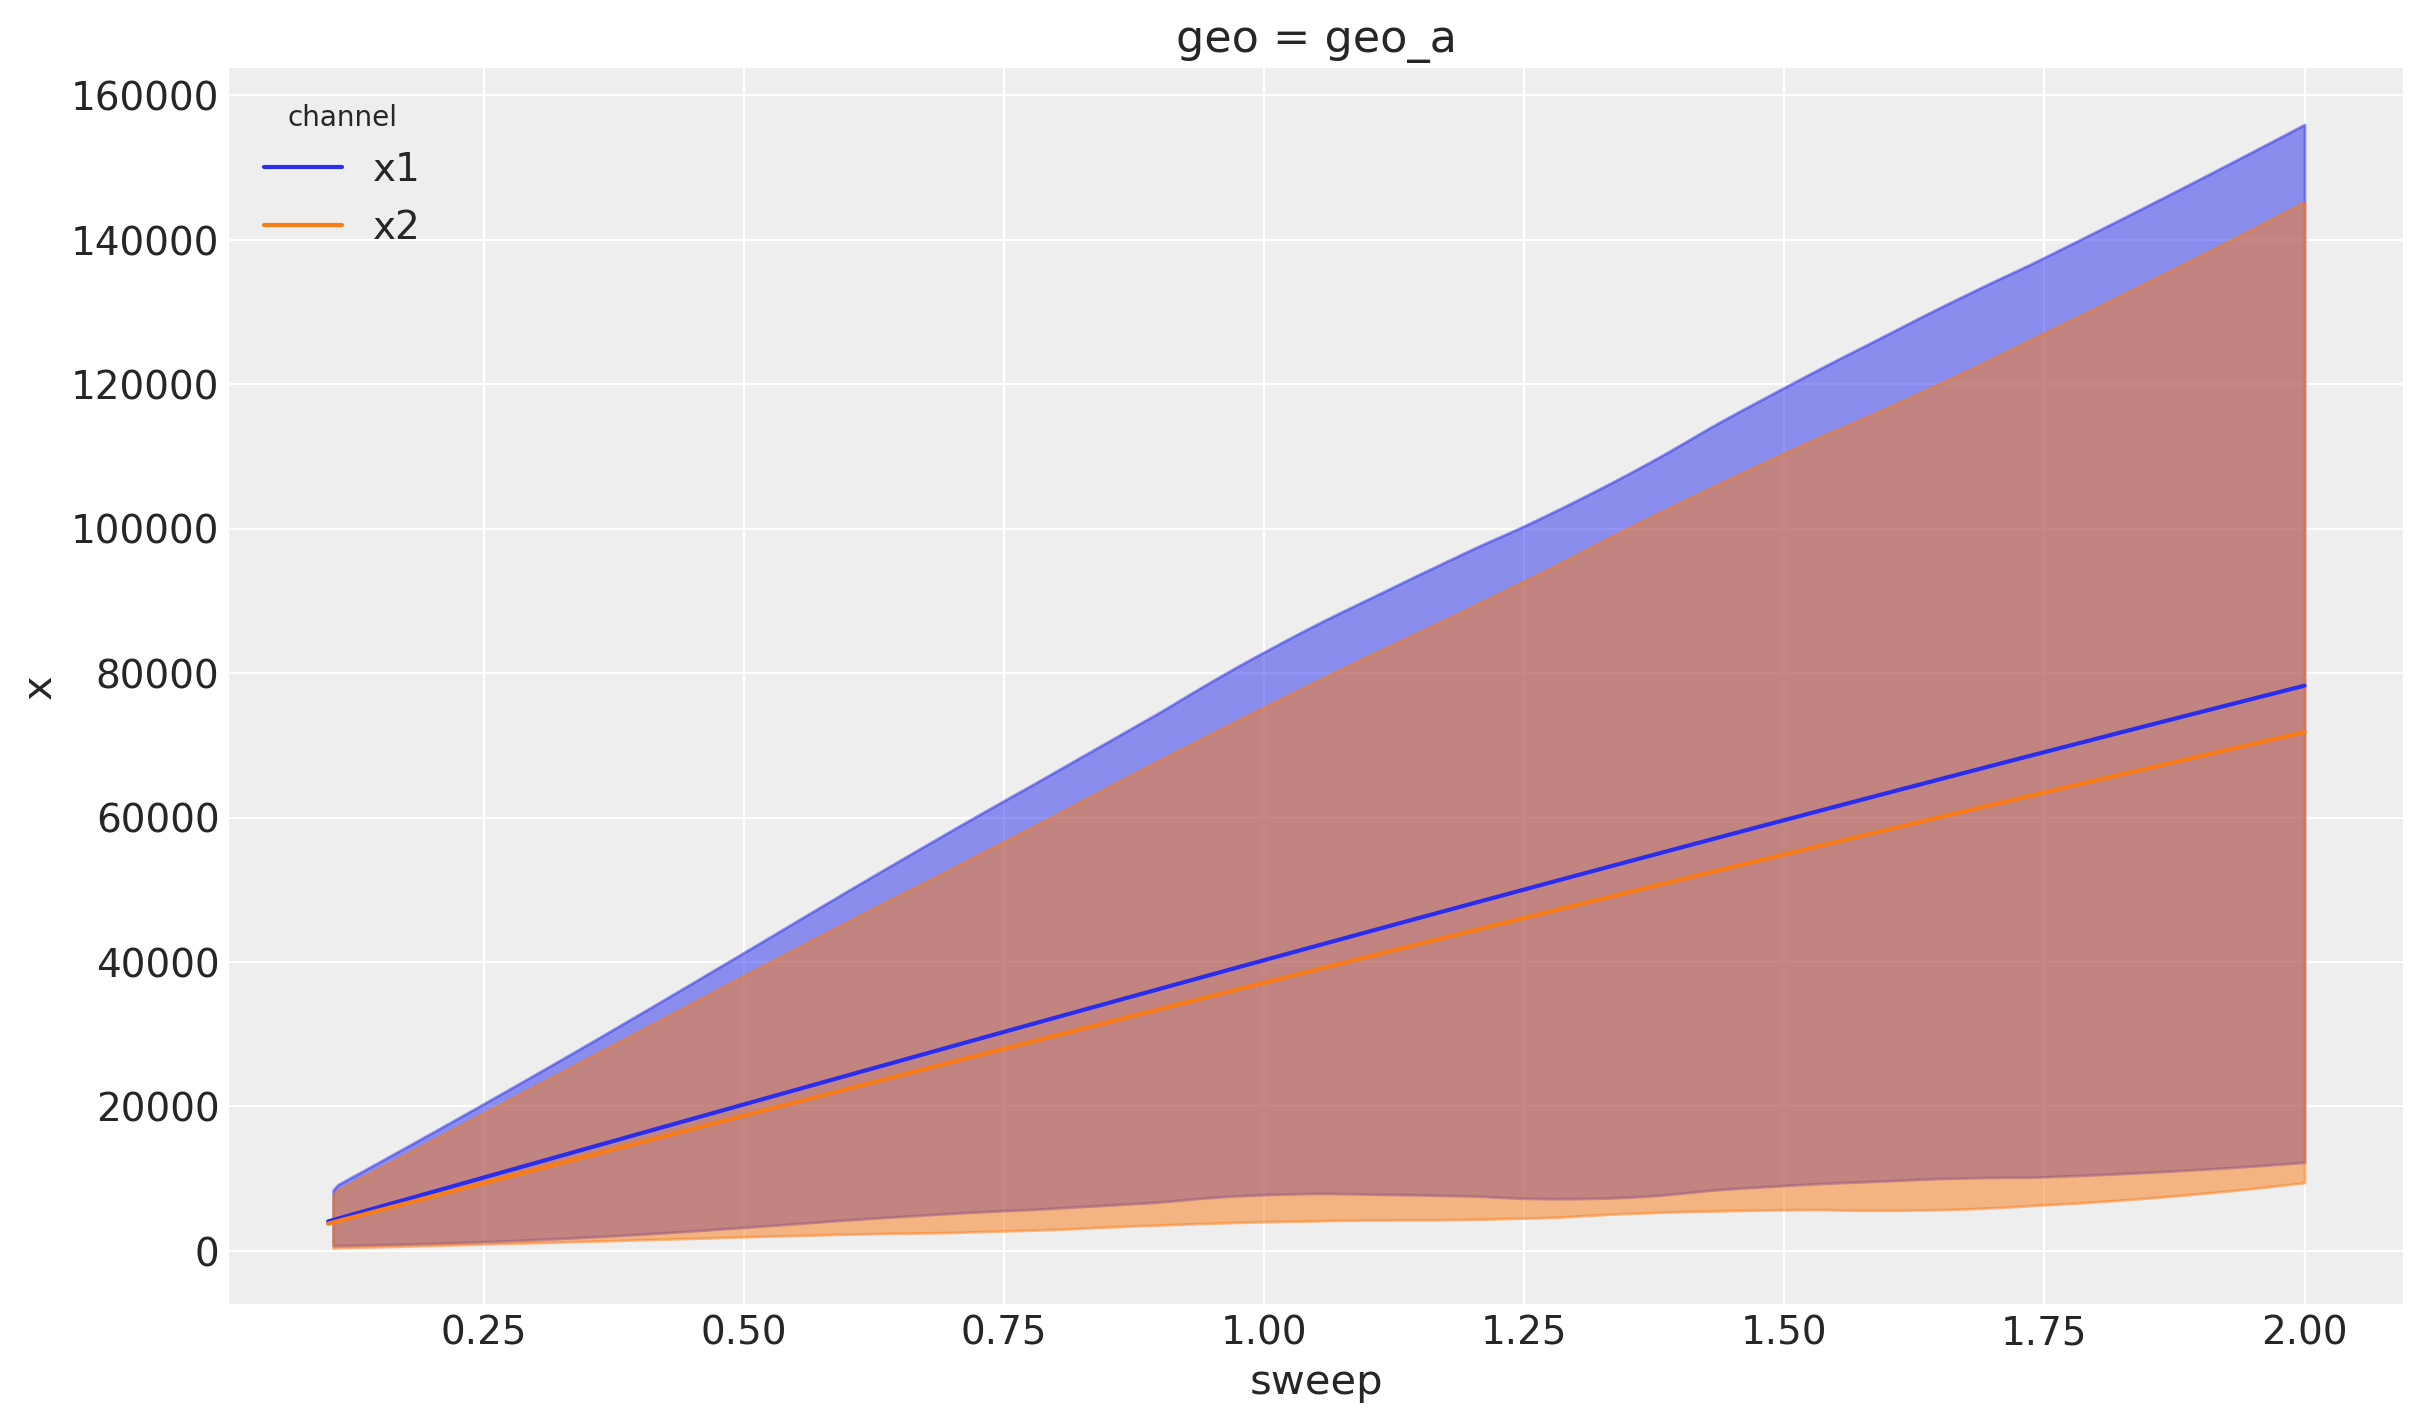

In [20]:
channels_geo_a = mmm.idata.sensitivity_analysis.sel(geo="geo_a")

# Plot the mean line
channels_geo_a.mean(dim=["sample"]).x.plot(hue="channel")

# For HDI, iterate over channels and pass DataArrays
for index, channel in enumerate(channels_geo_a.coords["channel"].values):
    az.plot_hdi(
        x=channels_geo_a.coords["sweep"],  # or whatever your x-axis coordinate is
        y=channels_geo_a["x"].sel(channel=channel),  # DataArray, not Dataset
        hdi_prob=0.94,
        color=f"C{index}",
    )

### Aggregating Across Geographies

Use the `aggregation` parameter to combine results across dimensions. This is useful when you want to see the total impact across all markets:

/Users/carlostrujillo/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/plot.py:2520: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


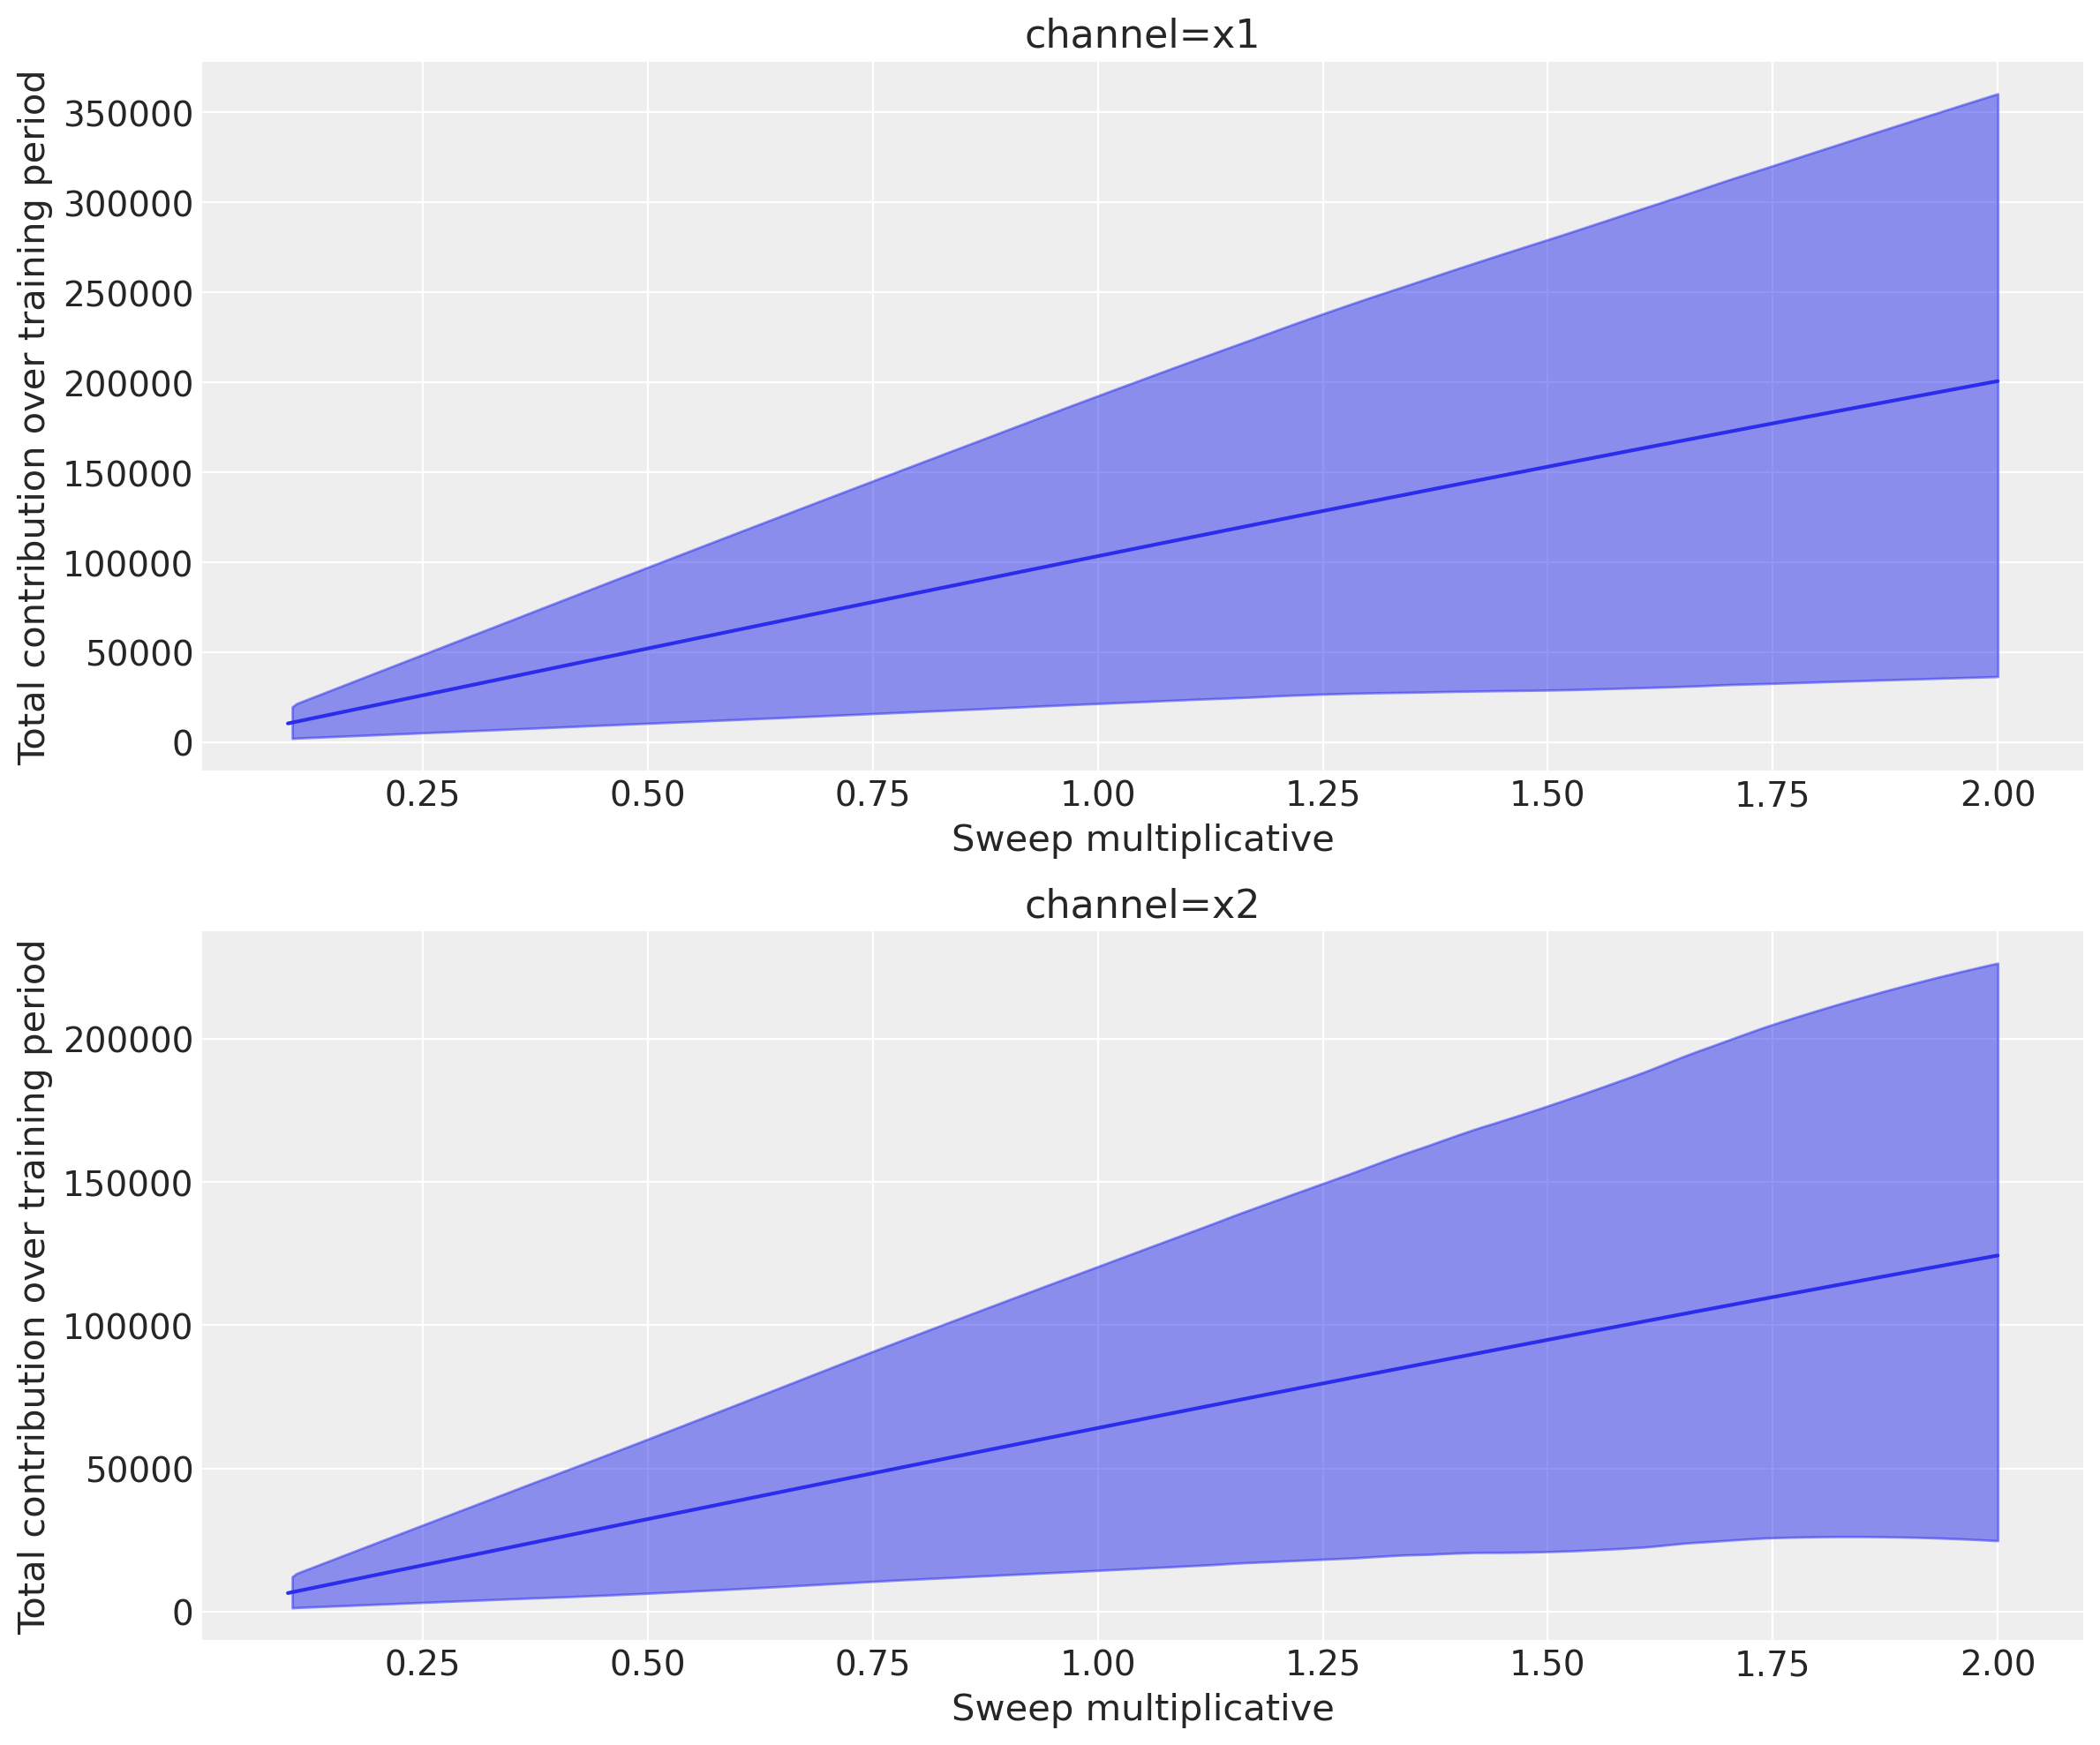

In [21]:
fig, axes = mmm.plot.sensitivity_analysis(
    xlabel="Sweep multiplicative",
    ylabel="Total contribution over training period",
    aggregation={"sum": ("geo",)},
    subplot_kwargs={"figsize": (12, 10), "nrows": 2},
)

Supported aggregation operations:
- `"sum"`: Sum contributions across the specified dimensions
- `"mean"`: Average contributions across the specified dimensions
- `"median"`: Median contributions across the specified dimensions

## Summary

In this tutorial, we explored two complementary ways to visualize media saturation in Marketing Mix Models:

1. **`saturation_scatterplot`**: Shows the direct/marginal relationship between spend and contribution at each time point. Best for understanding the shape of saturation and validating model behavior.

2. **`sensitivity_analysis`**: Shows how total contribution changes as you scale overall spend. Best for budget planning, what-if analysis, and making allocation decisions.

Understanding the difference between these visualizations is crucial for correctly interpreting your MMM results and making informed marketing decisions.

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Mon Jan 19 2026

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.6.0

pymc    : 5.27.0
pytensor: 2.36.3

pymc_extras   : 0.4.1
pandas        : 2.3.3
arviz         : 0.22.0
preliz        : 0.21.0
numpy         : 2.3.3
seaborn       : 0.13.2
matplotlib    : 3.10.6
pymc_marketing: 0.17.1

Watermark: 2.5.0

